# Twitter Advertising

### A Capstone project by Elliot Contreras

I chose to do my capstone project on Natural Language Processing (NLP) of Twitter tweets. I found that after doing projects on predicting prices, and classifying jobs, I wanted to explore something a bit more abstract. In order for me to get a better understanding of NLP and its uses, I chose to use public data from the social media website Twitter.

This project is geared more towards advertisers, marketing, and any company who wishes to leverage NLP for their company use. Through NLP of tweets, a company could gauge how people are feeling about their product. There are several stages to my project, and many directions to how the information could be used.

Pipeline:
- Mine tweets from Twitter API, save onto a Pandas Dataframe, and clean the information
- Feature extraction from tweets through VADER Sentiment Analysis, Nodebox psychological content analysis, coordinate extraction, source extraction, tokenization of text.
- Exploratory data analysis (EDA) of collected information. Trends over time, potential users who speak about the brand, distribution of data.
- Modeling phase includes 1. Word Recommendation System, 2. Sentiment Classifier, 3. User Aggregation, 4. Location Search

This is a technical report heavy on the coding side. Python is the main language, and a small amount of JSON is accessed. Please refer to Google if you are interested in any of the code.

## Mining Tweets

The mining of tweets refers to the automated gathering of public tweets and the processing of said information.

In [2]:
# Importing of the several packages. 
# Two api's will be used. Twitter and Tweepy.

import twitter, re, datetime, tweepy, pytz, unidecode, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# There are a few keys we need to get before we can continue forward. These are used to access the twitter api.
# Refer to https://dev.twitter.com/ in order to get your own twitter keys.

# your keys go here:
twitter_keys = {
    'consumer_key':        'CONSUMER_KEY',
    'consumer_secret':     'CONSUMER_SECRET',
    'access_token_key':    'ACCESS_TOKEN_KEY',
    'access_token_secret': 'ACCESS_TOKEN_SECRET'
}

# ORIGINAL TWITTER API
api = twitter.Api(
    consumer_key         =   twitter_keys['consumer_key'],
    consumer_secret      =   twitter_keys['consumer_secret'],
    access_token_key     =   twitter_keys['access_token_key'],
    access_token_secret  =   twitter_keys['access_token_secret']
)

# TWITTER CALL!!!!

# BELOW IS THE TWEEPY API
auth = tweepy.OAuthHandler(twitter_keys['consumer_key'], 
                           twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token_key'],
                      twitter_keys['access_token_secret'])

api_tweepy = tweepy.API(auth)

# BOTH APIS WILL BE USED. TWITTER.API FOR THE THE TWITTER MINING
# TWEEPY API FOR TREND SEARCH, AND JSON OBJECT EXTRACTION

The following functions will be used in the pre-processing of tweets

In [3]:
# TIME VARIABLE BELOW WILL BE USED MULTIPLE TIMES FOR SAVING CSV
# POSSIBLY FOR A TIME CHECK TO MAKE SURE TWITTER CALLS ARE WITHIN TIME LIMIT

# Current time in UTC
def current_pacific_time():
    # Format year, month, date, hour, minute, second
    fmt = '%Y_%m_%d_%H_%M_%S'
    now_utc = datetime.datetime.now(pytz.timezone('UTC'))
    # UTC to pacific time
    now_pacific = now_utc.astimezone(pytz.timezone('US/Pacific'))
    # Pacific time in the given format above
    return now_pacific.strftime(fmt)

# CALL THIS VARIABLE BEFORE SAVING SO CURRENT PACIFIC TIME IS EMBEDDED
current_pacific_time()

'2017_05_25_15_48_00'

In [4]:
# CLEAN HASHTAGS
def clean_hashtags(row):
    if row.startswith('#'):
        #print row
        pass
    else:
        # Removes spaces and adds a # to the beginning of the hashtag word
        row = ''.join(('#', row.replace(' ','')))
        #print row
    return row

In [5]:
# Function to convert utc timestamp to pacific timestamp
def created_at_to_pacific(row):
    try:
        row = str(row)
        #format
        t = datetime.datetime.strptime(row, "%Y-%m-%d %H:%M:%S")
        t = t.replace(tzinfo=pytz.timezone('UTC'))
        # timezone as pacific
        t = t.astimezone(pytz.timezone('US/Pacific'))
        return t
    except:
        return row

In [6]:
# For the source variable, I want to remove all html links
# This function takes care of that.
def clean_source(row):
    try:
        row = re.findall(r'>(.*)<', row)[0]
        return row
    except:
        return row

In [7]:
# Tokenization function to remove html tags, @mentions, urls

# USING REGEX TO TOKENIZE AND CLEAN TWEETS TEXT 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r"\\u....", # Unicode characters
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]



tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '[', ']', '{', '}', ';',
                 ':', ',', '.', '/', '<', '>', '?', '\\', '|', "'", '`', '~', '-', '=', '_',
                 '+', '"', 'rt', 'RT', 'rT', 'Rt']
 
def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s, lowercase=True):
    try:
        s = s.encode('ascii', 'ignore')
        tokens = tokenize(s)
        if lowercase:
            tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
        for token in tokens:
            # REMOVE @MENTIONS
            if re.findall(r'(?:@[\w_]+)', token):
                tokens.remove(token)
            # REMOVE HTTP LINKS
            if re.findall(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', token):
                tokens.remove(token)
            # REMOVE UNICODE/EMOJI
            if re.findall(r"\\u....", token):
                tokens.remove(token)
        for token in tokens:
            # REMOVE SINGLE SPECIAL CHARACTERS
            if token in special_chars:
                tokens.remove(token)
    
        return ' '.join(tokens)
    except:
        pass
        #print s

        
tweet = u'RT @marcobonzanini: just an example! \ud83c \udfa4 \ud83d :D http://example.com #NLP'
# data.encode('utf8') 
#tweet = tweet.encode('utf8')
print(preprocess(preprocess(tweet)))

just an example :D #nlp


In [8]:
# This function returns a list of words, only letters, stopwords removed and lowercased
from nltk.corpus import stopwords

def words_to_wordlist( row, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", row)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [9]:
# These functions are used for the bing maps api call
# Using the location column from the tweets dataset and returning lat/long coordinates

import urllib2, json, string

def bing_search(s):
    '''Given a string, returns a formatted string to be used in a bing maps search.
    '''
    try:
        return '%20'.join(s.translate(None, string.punctuation).lower().split())+'?'
    except:
        bing_search(' '.join(words_to_wordlist(s)))
# bing_search(addy)

def bing_maps_coords(row):
    '''Given a search query, does a bing maps search and returns coordinates for location.
    Requires the following modules to be imported:
    import urllib2, json
    '''
    sf_coords = [37.7771186828613, -122.419639587402]
    
    # Your Bing Maps Key 
    bingMapsKey = "BING_MAPS_KEY"
    
    # URL
    routeUrl = 'http://dev.virtualearth.net/REST/v1/Locations/'+ bing_search(row) +'&key='+ bingMapsKey
    
    try:
        response = urllib2.urlopen(routeUrl)
        r = response.read().decode(encoding="utf-8")
        result = json.loads(r)
        return result['resourceSets'][0]['resources'][0]['point']['coordinates']
    except:
        return bing_maps_coords('San Francisco, CA')

In [10]:
# This is the function that will be used .map on the location column
def get_coordinates(row):
    sf = [37.7771186828613, -122.419639587402]
    if row == 'San Francisco, CA':
        return sf
    else:
        row = preprocess(preprocess(row))
        row = words_to_wordlist(row)
        row = ' '.join(row)
        return bing_maps_coords(row)

In [12]:
# Master function to run all cleaning functions

def clean_tweetmined_df(df):
    try:
        df['hashtags']    = df['hashtags'].map(lambda x: clean_hashtags(unidecode.unidecode(x)))
    except:
        pass
    df['created_at']  = pd.to_datetime(df['created_at'])
    df['created_at']  = df['created_at'].map(lambda x: created_at_to_pacific(x))
    df['source']      = df['source'].map(lambda x: clean_source(unidecode.unidecode(x)))
    df['text']        = df['text'].map(lambda x: preprocess(preprocess(unidecode.unidecode(x))))
    try:
        df['location']= df['location'].map(lambda x: 'San Francisco, CA' if len(str(x))==0 else x)
    except:
        pass
    try:
        df['location']= df['location'].map(lambda x: 'San Francisco, CA' if pd.isnull(x) else x)
    except:
        pass
    df['coordinates'] = df['location'].map(lambda x: get_coordinates(x))
    
    print 'Cleaned DataFrame!'
    return df

In [13]:
# exporting tweets dataframe, so information can be used later on
def save_dataframe(df, name='some_text'):
    if type(df) == pd.core.frame.DataFrame:
        df.to_csv('./'+name+'_'+current_pacific_time()+'.csv', encoding='utf-8', index=False)
        print 'Exported to: ./'+name+'_'+current_pacific_time()+'.csv'
    else:
        print 'No dataset selected'

In [14]:
# Thank you to David Yerrygton for writing this TweetMiner Class. 
# It has been edited in order for tweets to be properly formatted.


class TweetMiner(object):

    result_limit    =   100    
    api             =   False
    data            =   []
    
    
    def __init__(self, keys_dict, api, result_limit = 20):
        
        self.api = api
        self.twitter_keys = keys_dict
        
        self.result_limit = result_limit
        

    def mine_user_tweets(self, user="twitter", mine_rewteets=False, max_pages=15):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id - 1)        
            else:
                statuses   =   self.api.GetUserTimeline(screen_name=user, count=self.result_limit)
                
            for item in statuses:
                
                mined = {
                    'screen_name' :    item.user.screen_name,
                    'retweet_count':   item.retweet_count,
                    'text':            item.text,
                    'mined_at':        datetime.datetime.now(),
                    'created_at':      item.created_at,
                    'hashtags' : item.hashtags,
                    'source' : item.source,
                    'location' : item.user.location,
                    'coordinates' : item.coordinates,
                    'retweet_count': item.retweet_count,
                    'favorite_count': item.favorite_count
                }

                last_tweet_id = item.id
                data.append(mined)
                
            page += 1
            
        return data
    
    def mine_search_tweets(self, term='#twitter', until=None, since=None, mine_rewteets=False, max_pages=20):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetSearch(term=term, 
                                                  until=None, 
                                                  since=None,
                                                  count=self.result_limit, max_id=last_tweet_id - 1)        
            else:
                statuses   =   self.api.GetSearch(term=term, 
                                                  until=None, 
                                                  since=None,
                                                  count=self.result_limit)
                
            for item in statuses:
                
                mined = {
                    'screen_name' :    item.user.screen_name,
                    'retweet_count':   item.retweet_count,
                    'text':            item.text,
                    'mined_at':        datetime.datetime.now(),
                    'created_at':      item.created_at,
                    'hashtags' : term,
                    'source' : item.source,
                    'location' : item.user.location,
                    'coordinates' : item.coordinates,
                    'retweet_count': item.retweet_count,
                    'favorite_count': item.favorite_count
                }
                
                last_tweet_id = item.id
                data.append(mined)
                
            page += 1
            
        return data
    
    # General Assembly coordinates
    lat =  37.7908730
    lon = -122.4012970
    radius = '5mi'
    
    def mine_location_tweets(self, geocode=[lat, lon, radius], mine_rewteets=False, max_pages=15):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses   =   self.api.GetSearch(geocode=geocode, count=self.result_limit, max_id=last_tweet_id - 1)        
            else:
                statuses   =   self.api.GetSearch(geocode=geocode, count=self.result_limit)
                
            for item in statuses:
                
                mined = {
                    'screen_name' :    item.user.screen_name,
                    'retweet_count':   item.retweet_count,
                    'text':            item.text,
                    'mined_at':        datetime.datetime.now(),
                    'created_at':      item.created_at,
                    'hashtags' : item.hashtags,
                    'source' : item.source,
                    'location' : item.user.location,
                    'coordinates' : item.coordinates,
                    'retweet_count': item.retweet_count,
                    'favorite_count': item.favorite_count
                }
                
                last_tweet_id = item.id
                data.append(mined)
                
            page += 1
            
        return data

tm = TweetMiner(api=api, keys_dict=twitter_keys)

In [ ]:
### CODE BELOW WILL BE USED ### CODE BELOW WILL BE USED ### CODE BELOW WILL BE USED ### CODE BELOW WILL BE USED ###

In [15]:
# TWITTER CALL!!!!

# getting the trends available for the world
world_trends = api_tweepy.trends_available()
print 'world trends...', current_pacific_time()

# converting into a dataframe
world_trends_df = pd.DataFrame(world_trends)

# Selecting only the trends from USA
usa_trends_df = world_trends_df[ world_trends_df['countryCode'] == 'US' ]

world trends... 2017_05_25_15_48_17


In [16]:
# will use the 'woeid' in order to gather the trends per city in the usa_trends_df

# TWITTER CALL!!!!

usa_trends_list = []

for row in range(usa_trends_df.shape[0]):
    usa_trends_list.append(api_tweepy.trends_place(usa_trends_df.iloc[row]['woeid'])[0]['trends'])
    
# the trends do not have the location within them, so I am adding what city they came from
for index, group in enumerate(usa_trends_list):
    for d in group:
        d['city'] = usa_trends_df.iloc[index]['name']
        
# Converting the trends into dataframes, then concatenating them together into one
temp_list = []
for index, group in enumerate(usa_trends_list):
    temp_pd = pd.DataFrame(usa_trends_list[index]).sort_values('tweet_volume', ascending=False).head(10)
    temp_list.append(temp_pd)


top_ten_trends_in_usa = pd.concat(temp_list)

The first step in the mining process is to return the top ten trends per city in the United States.

In [17]:
top_ten_trends_in_usa['name'] = top_ten_trends_in_usa['name'].map(lambda x: clean_hashtags(x))
top_ten_trends_in_usa.head()

,city,name,promoted_content,query,tweet_volume,url
4,Albuquerque,#Manchester,None,Manchester,1706959.0,http://twitter.com/search?q=Manchester
6,Albuquerque,#NationalWineDay,None,%23NationalWineDay,79035.0,http://twitter.com/search?q=%23NationalWineDay
16,Albuquerque,#Jupiter,None,Jupiter,39814.0,http://twitter.com/search?q=Jupiter
8,Albuquerque,#MarkZuckerberg,None,%22Mark+Zuckerberg%22,39372.0,http://twitter.com/search?q=%22Mark+Zuckerberg%22
41,Albuquerque,#SVGala6,None,%23SVGala6,35748.0,http://twitter.com/search?q=%23SVGala6


In [18]:
# exporting top_ten_trends_in_usa dataframe, so information can be used later on

save_dataframe(df=top_ten_trends_in_usa, name='trends_in_usa')

Exported to: ./trends_in_usa_2017_05_25_15_48_39.csv


In [19]:
# Ranking the trends per city. Within the top ten, the top gets ranked a one, the bottom gets ranked a .1
# This goes through every cities top ten
# My choice for this is becuase there are similar trends in other cities,
# but vary in what position per city
trends_dict = {}
us_cities = list(top_ten_trends_in_usa['city'].unique())

for city in us_cities:
    tt = top_ten_trends_in_usa[top_ten_trends_in_usa['city'] == city].sort_values('tweet_volume', ascending=False)['name'].values
    tt = list(reversed(tt))
    for index, trend in enumerate(tt):
        if trend not in trends_dict:
            trends_dict[trend] = (index + 1) / 10.
        else:
            trends_dict[trend] += (index + 1) / 10.

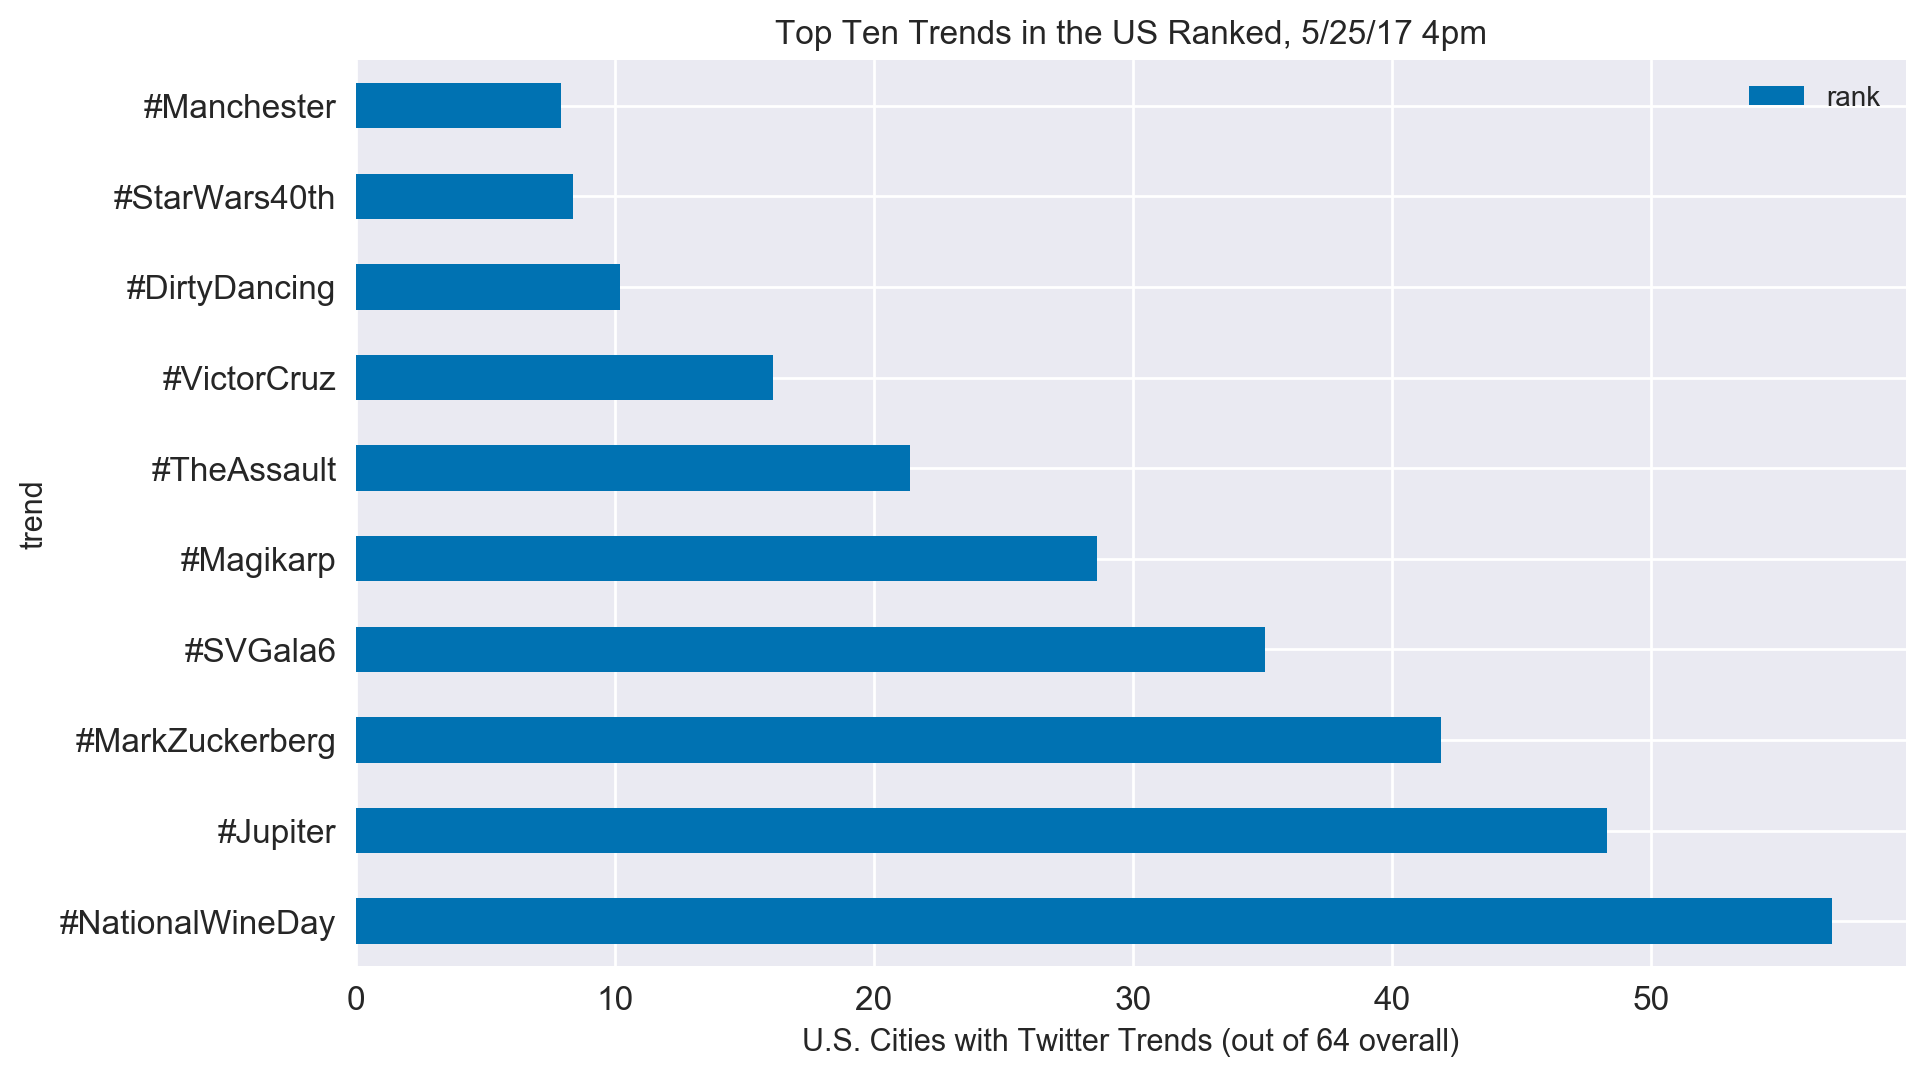

In [28]:
# Plotting of the ranked trends
sns.set_palette("colorblind")
fig, ax = plt.subplots(figsize=(10,6), dpi=200)

# Taking the trends ranked dictionary and converting it to a dataframe
us_trends_ranked_df = pd.DataFrame(trends_dict.items(), columns=['trend', 'rank'])
us_trends_ranked_df = us_trends_ranked_df.sort_values('rank', ascending=False)
us_trends_ranked_df.reset_index(drop=True, inplace=True)

# Looking at the Top Ten trends ranked in the US
us_trends_ranked_df.head(10).plot('trend', ax=ax, legend=True, kind='barh', fontsize=12, title='Top Ten Trends in the US Ranked, 5/25/17 4pm')
ax.set_xlabel('U.S. Cities with Twitter Trends (out of 64 overall)')

In [20]:
# Creating a list of the top ten trends
top_ten = []
for i in range(len(us_trends_ranked_df.head(10).values)):
    top_ten.append(list(us_trends_ranked_df.head(10).values)[i][0])
top_ten

[u'#loveislove',
 u'#STRIPTHATDOWN',
 u'#wednesdaywisdom',
 u'#ChelseaManning',
 u'#IDAHOT',
 u'#Trump',
 u'#LavarBall',
 u'#IO17',
 u'#LeGarretteBlount',
 u'#TrumpsLegacyWillBe']

In [24]:
# TWITTER CALL!!!!

# Using the hashtags to mine tweets
tweets_list = []
for trend in top_ten:
    # Tweets are mined and saved onto a dataframe
    temp_df = pd.DataFrame(tm.mine_search_tweets(term=unidecode.unidecode(trend), max_pages=15))
    tweets_list.append(temp_df)
    
# Creating a dataframe from gathered tweets
tweets_df = pd.concat(tweets_list)


DONE!
CPU times: user 3 µs, sys: 5 µs, total: 8 µs
Wall time: 11 µs
-1:59:59


In [25]:
# Looking at the first five entries
tweets_df.head()

,coordinates,created_at,favorite_count,hashtags,location,mined_at,retweet_count,screen_name,source,text
0,None,Wed May 17 16:29:43 +0000 2017,15745,#loveislove,California,2017-05-17 11:25:23.311230,6820,TheEllenShow,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Today’s a great day to show love to someone wh...
1,None,Wed May 17 14:52:51 +0000 2017,3870,#loveislove,"Itápolis, Brasil",2017-05-17 11:25:23.311246,5567,cleytu,"<a href=""http://twitter.com/download/iphone"" r...",recadinho #loveislove https://t.co/RWmjbaryMf
2,None,Wed May 17 10:35:16 +0000 2017,3548,#loveislove,"São Paulo, Brasil",2017-05-17 11:25:23.311251,4324,momentsbrasil,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Dia 17 de Maio &gt; Dia Internacional de Comba...
3,None,Wed May 17 18:25:07 +0000 2017,0,#loveislove,Brasil,2017-05-17 11:25:23.311255,80,mdstalis,"<a href=""http://twitter.com/download/iphone"" r...",RT @lovatocoldx: eu posso ver esse vídeo 1 mil...
4,None,Wed May 17 18:25:07 +0000 2017,0,#loveislove,Anahi;Dany;BF,2017-05-17 11:25:23.311259,1,prettyportilla,"<a href=""http://twitter.com/download/android"" ...","RT @offnarri: #loveislove ""Tu decides a quem a..."


In [1]:
# Cleaning the tweets dataset
tweets_df = clean_tweetmined_df(tweets_df)

In [29]:
df = tweets_df.copy()

In [30]:
# The tweets have been cleaned!
df.head()

,coordinates,created_at,favorite_count,hashtags,location,mined_at,retweet_count,screen_name,source,text
0,"[37.2550964355, -119.617523193]",2017-05-17 09:29:43-07:00,15745,#loveislove,California,2017-05-17 11:25:23.311230,6820,TheEllenShow,Twitter Web Client,today's a great day to show love to someone wh...
1,"[-21.596200943, -48.8115692139]",2017-05-17 07:52:51-07:00,3870,#loveislove,"Itápolis, Brasil",2017-05-17 11:25:23.311246,5567,cleytu,Twitter for iPhone,recadinho #loveislove
2,"[-23.5629005432, -46.6547088623]",2017-05-17 03:35:16-07:00,3548,#loveislove,"São Paulo, Brasil",2017-05-17 11:25:23.311251,4324,momentsbrasil,Twitter Web Client,dia 17 de maio gt dia internacional de combate...
3,"[-10.8104524612, -52.9731178284]",2017-05-17 11:25:07-07:00,0,#loveislove,Brasil,2017-05-17 11:25:23.311255,80,mdstalis,Twitter for iPhone,eu posso ver esse video 1 milhao de vezes e se...
4,"[12.2849855423, -1.74556100369]",2017-05-17 11:25:07-07:00,0,#loveislove,Anahi;Dany;BF,2017-05-17 11:25:23.311259,1,prettyportilla,Twitter for Android,#loveislove tu decides a quem a amar libertad ...


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 299
Data columns (total 10 columns):
coordinates       600 non-null object
created_at        600 non-null datetime64[ns, US/Pacific]
favorite_count    600 non-null int64
hashtags          600 non-null object
location          600 non-null object
mined_at          600 non-null datetime64[ns]
retweet_count     600 non-null int64
screen_name       600 non-null object
source            600 non-null object
text              600 non-null object
dtypes: datetime64[ns, US/Pacific](1), datetime64[ns](1), int64(2), object(6)
memory usage: 51.6+ KB


## Feature Extraction

In [3]:
# Importing more packages
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import unidecode
import string
import re
import pytz
import gensim
import datetime
from gensim.models.word2vec import Word2Vec 
import matplotlib.pyplot as plt
import en
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
pd.set_option("display.max_colwidth",101)

from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from multiprocessing import Pool

# import vader for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# import textblob for secondary sentiment analysis
from textblob import TextBlob

# stemmer to return words to base phrases
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')

# getting stop words ready
stop_words = list(ENGLISH_STOP_WORDS)
stop_words += stopwords.words()
stop_words = list(set(stop_words))
stop_words += ['fucking','shit','fuck','htt', 'com', 'k', 'https', 'its', 'n', 'a', 'e', 'i', 'o', 'u', 'th', 'el',
              'on', 'for', 'us', 'w', 'and', 'http', 'had', 'to', 'didn', 'doesn', 'wasn', 'isn',
              'm', 't', 'il']

Using TensorFlow backend.


In [ ]:
# import vader for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [ ]:
# Getting the sentiment scores for every tweet
def get_sentiment_scores(df):
    df['compound'] = df['text'].map(lambda x: analyser.polarity_scores(str(x).replace('#', ''))['compound'])
    df['pos']      = df['text'].map(lambda x: analyser.polarity_scores(str(x).replace('#', ''))['pos'])
    df['neu']      = df['text'].map(lambda x: analyser.polarity_scores(str(x).replace('#', ''))['neu'])
    df['neg']      = df['text'].map(lambda x: analyser.polarity_scores(str(x).replace('#', ''))['neg'])
    return df

df = get_sentiment_scores(df)

In [18]:
# Nodebox Psychological analysis
def get_psyche_analysis_01(row):
    summary = en.content.categorise(str(row))
    return float("{0:.2f}".format(summary.primary))

def get_psyche_analysis_02(row):
    summary = en.content.categorise(str(row))
    return float("{0:.2f}".format(summary.secondary))

def get_psyche_analysis_03(row):
    summary = en.content.categorise(str(row))
    return float("{0:.2f}".format(summary.emotions))

df['primary']   = df.text.map(get_psyche_analysis_01)
df['secondary'] = df.text.map(get_psyche_analysis_02)
df['emotions']  = df.text.map(get_psyche_analysis_03)
df.sample()

,coordinates,created_at,favorite_count,hashtags,location,mined_at,retweet_count,screen_name,source,text,...,token_text,polarity,compound,pos,neu,neg,compound_boosted,primary,secondary,emotions
created_at,,,,,,,,,,,,,,,,,,,,,
2017-05-27 12:02:31-07:00,"[37.7771186829, -122.419639587]",2017-05-27 12:02:31-07:00,0,#Rinne,NaN,2017-05-31 19:52:19.161833,0,RodiRupi,Twitter Web Client,"descarga un nuevo capitulo de #kyoukainorinne tv 3 rd season capitulo 8, ya disponible #rinne",...,"[descarga, nuevo, capitulo, kyoukainorinne, tv, rd, season, capitulo, disponible, rinne]",0.0,0.0,0.0,1.0,0.0,-0.6249,0.0,1.0,0.0


In [ ]:
# getting the word count of a tweet and turning it into a feature
def get_word_count(row):
    return len(str(row).split())

# new version with multiprocessor
p = Pool(4)
df['word_count'] = p.map(get_word_count, df.text)
p.close() 
p.join()

In [ ]:
# getting the character length of a tweet and turning it into a feature
def get_length_tweet(row):
    return len(str(row))

# new version with multiprocessor
p = Pool(4)
df['tweet_length'] = p.map(get_length_tweet, df.text)
p.close() 
p.join() 

In [ ]:
# Getting coordinates into their respected lat/long columns
def get_latitude(row):
    return float(row.lstrip('[').rstrip(']').split(', ')[0])

def get_longitude(row):
    return float(row.lstrip('[').rstrip(']').split(', ')[1])

# new version with multiprocessor
p = Pool(4)
df['latitude']  = p.map(get_latitude,  df.coordinates)
df['longitude'] = p.map(get_longitude, df.coordinates)
p.close() 
p.join()

## EDA

Extraploratory Data Analysis

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38702 entries, 0 to 10489
Data columns (total 24 columns):
created_at          38702 non-null object
coordinates         38702 non-null object
favorite_count      38702 non-null float64
hashtags            38702 non-null object
location            35626 non-null object
mined_at            38702 non-null object
retweet_count       38702 non-null float64
screen_name         38702 non-null object
source              38702 non-null object
text                38694 non-null object
token_text          38702 non-null object
tweet_length        38702 non-null int64
word_count          38702 non-null int64
latitude            38702 non-null float64
longitude           38702 non-null float64
compound            38702 non-null float64
pos                 38702 non-null float64
neu                 38702 non-null float64
neg                 38702 non-null float64
polarity            38702 non-null float64
compound_boosted    38702 non-null float64
p

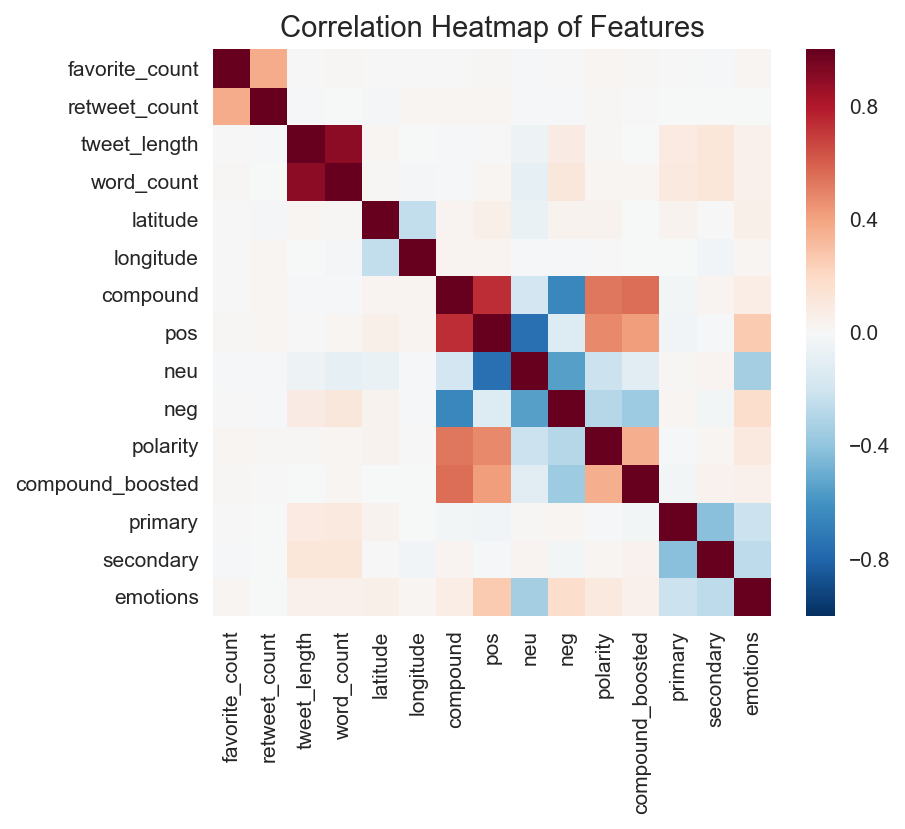

In [28]:
# graphing the sentiment count
fig, ax = plt.subplots(figsize=(6,5), dpi=150)
sns.heatmap(df.corr(), ax=ax)
ax.set_title('Correlation Heatmap of Features', fontsize=14)

In [30]:
# Seperating the tweets based on the sentiment value
neutral = df[df['compound']==0]
neutral.shape
positive = df[df['compound']>0]
negative = df[df['compound']<0]

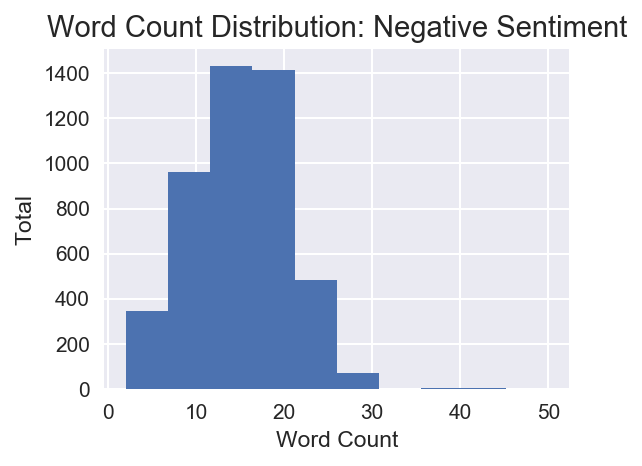

In [31]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
negative['word_count'].hist(ax=ax)
ax.set_title('Word Count Distribution: Negative Sentiment', fontsize=14)
ax.set_xlabel('Word Count')
ax.set_ylabel('Total')

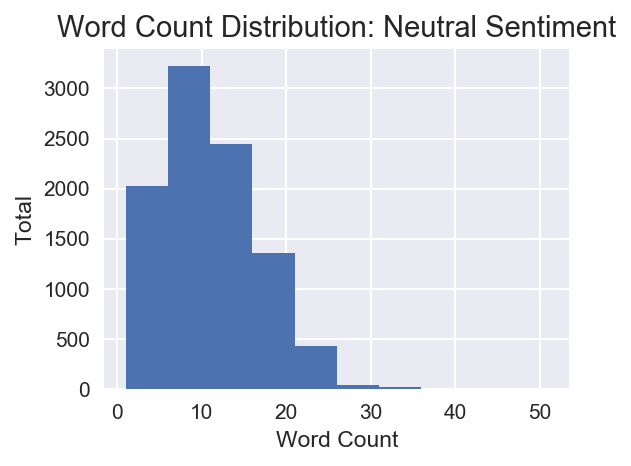

In [32]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
neutral['word_count'].hist(ax=ax)
ax.set_title('Word Count Distribution: Neutral Sentiment', fontsize=14)
ax.set_xlabel('Word Count')
ax.set_ylabel('Total')

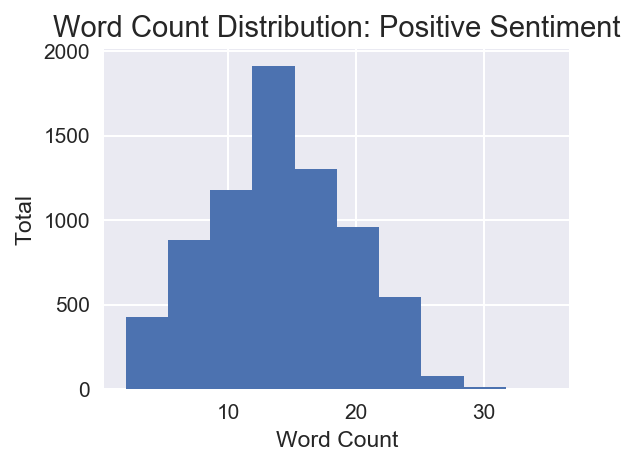

In [33]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
positive['word_count'].hist(ax=ax)
ax.set_title('Word Count Distribution: Positive Sentiment', fontsize=14)
ax.set_xlabel('Word Count')
ax.set_ylabel('Total')

The following is a seperate dataframe conducting tests on hotel tweets

In [10]:
# casting column into datetime format, establishing index, and removing said column
df.created_at = pd.to_datetime(df.created_at)
df.index = df.created_at
df.sort_index(inplace=True)
# df.drop('created_at', axis=1, inplace=True)
print df.shape
df.head(3)

(1443, 28)


,created_at,coordinates,created_at.1,favorite_count,hashtags,location,mined_at,retweet_count,screen_name,source,...,source_le,compound,pos,neu,neg,polarity,compound_boosted,primary,secondary,emotions
created_at,,,,,,,,,,,,,,,,,,,,,
2017-05-16 01:24:59,2017-05-16 01:24:59,"[37.7771186829, -122.419639587]",2017-05-16 01:24:59,0,#Wynn,"San Francisco, CA",2017-05-24 22:53:46.870696,0,Cobblezz,Instagram,...,21,0.2732,0.208,0.792,0.0,0.0,0.6908,0.0,0.0,0.0
2017-05-16 02:09:48,2017-05-16 02:09:48,"[37.7771186829, -122.419639587]",2017-05-16 02:09:48,2,#Intercontinental,"กรุงเทพมหานคร, ประเทศไทย",2017-05-24 23:15:54.439182,0,kanya_pie,Instagram,...,21,0.0000,0.000,1.000,0.0,0.0,0.0000,1.0,0.0,0.0
2017-05-16 02:48:12,2017-05-16 02:48:12,"[33.4482498169, -112.075798035]",2017-05-16 02:48:12,1,#Hyatt,"Phoenix, AZ",2017-05-24 22:02:21.110992,0,bohonus,RICOH THETA S for Android,...,33,0.0000,0.000,1.000,0.0,0.0,0.0000,1.0,0.0,0.0


In [23]:
# Getting the top count of hashtag use
df.hashtags.value_counts().head(10)

#Marriott            633
#Hyatt               525
#Wynn                164
#Intercontinental    121
Name: hashtags, dtype: int64

In [19]:
# Getting the top count of hashtag use
df.source.value_counts().head(10)

Twitter for iPhone     315
Work For Us            259
Twitter for Android    166
Instagram              165
Twitter Web Client     154
Hootsuite               80
IFTTT                   44
SocialOomph             31
Facebook                28
Buffer                  27
Name: source, dtype: int64

In [25]:
# Getting the top count of hashtag use
df[df['hashtags'] == '#Marriott'].source.value_counts().head(10)

Twitter for iPhone            180
Twitter for Android           105
Twitter Web Client             87
Instagram                      77
Hootsuite                      53
IFTTT                          25
Facebook                       20
Twitter for iPad               12
Buffer                         10
Mba Jobs in South Atlantic      8
Name: source, dtype: int64

In [56]:
df.screen_name.value_counts().head(10)

hyattjobs          206
TDS822              86
mabepio             41
JerseyKidPicks      28
Marriott_BosBur     18
GodLovesSchlubs     17
CoconutPoint        15
priscillaguasso     13
hotelauditorium     10
PinnacleUSAJobs     10
Name: screen_name, dtype: int64

In [99]:
df[df['hashtags']=='#Marriott'].shape

(892, 18)

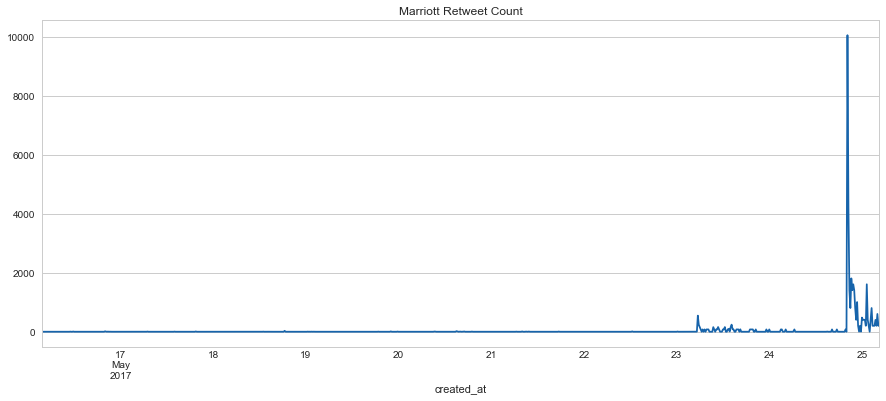

In [80]:
# graphing the retweet count
df[df['hashtags']=='#Marriott']['retweet_count'].resample('15T').sum().fillna(value=0).plot(figsize=(15,6), title='Marriott Retweet Count')

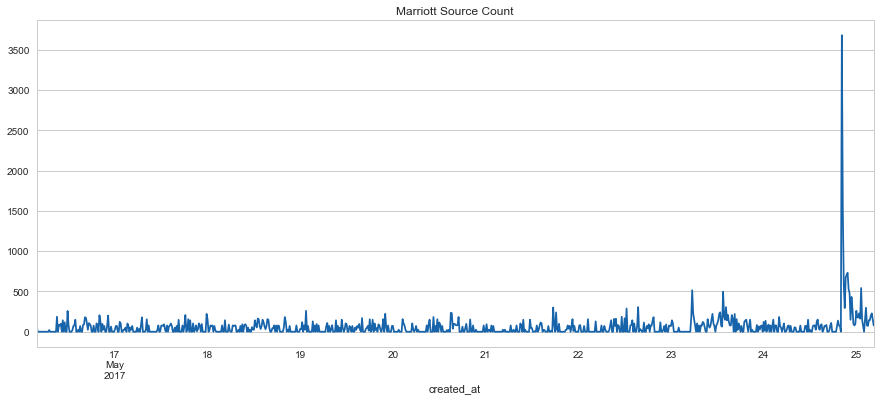

In [81]:
# graphing the retweet count
df[df['hashtags']=='#Marriott']['source_le'].resample('15T').sum().fillna(value=0).plot(figsize=(15,6), title='Marriott Source Count')


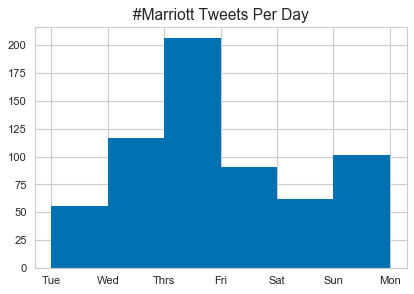

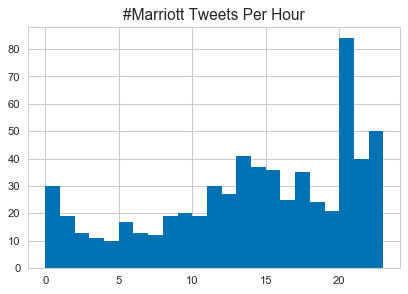

In [301]:
# Marriot hist of tweets per day
plt.figure(figsize=(6,4), dpi=80)
plt.title('#Marriott Tweets Per Day', fontsize=14)
plt.hist(df[df['hashtags']=='#Marriott']['created_at'].dt.weekday, bins=6)
plt.xticks(np.arange(7), ['Tue', 'Wed', 'Thrs', 'Fri', 'Sat', 'Sun', 'Mon'], rotation=0)
plt.show()

plt.figure(figsize=(6,4), dpi=80)
plt.title('#Marriott Tweets Per Hour', fontsize=14)
plt.hist(df[df['hashtags']=='#Marriott']['created_at'].dt.hour, bins=23)
#plt.xticks(np.arange(7), ['Tue', 'Wed', 'Thrs', 'Fri', 'Sat', 'Sun', 'Mon'], rotation=0)
plt.show()

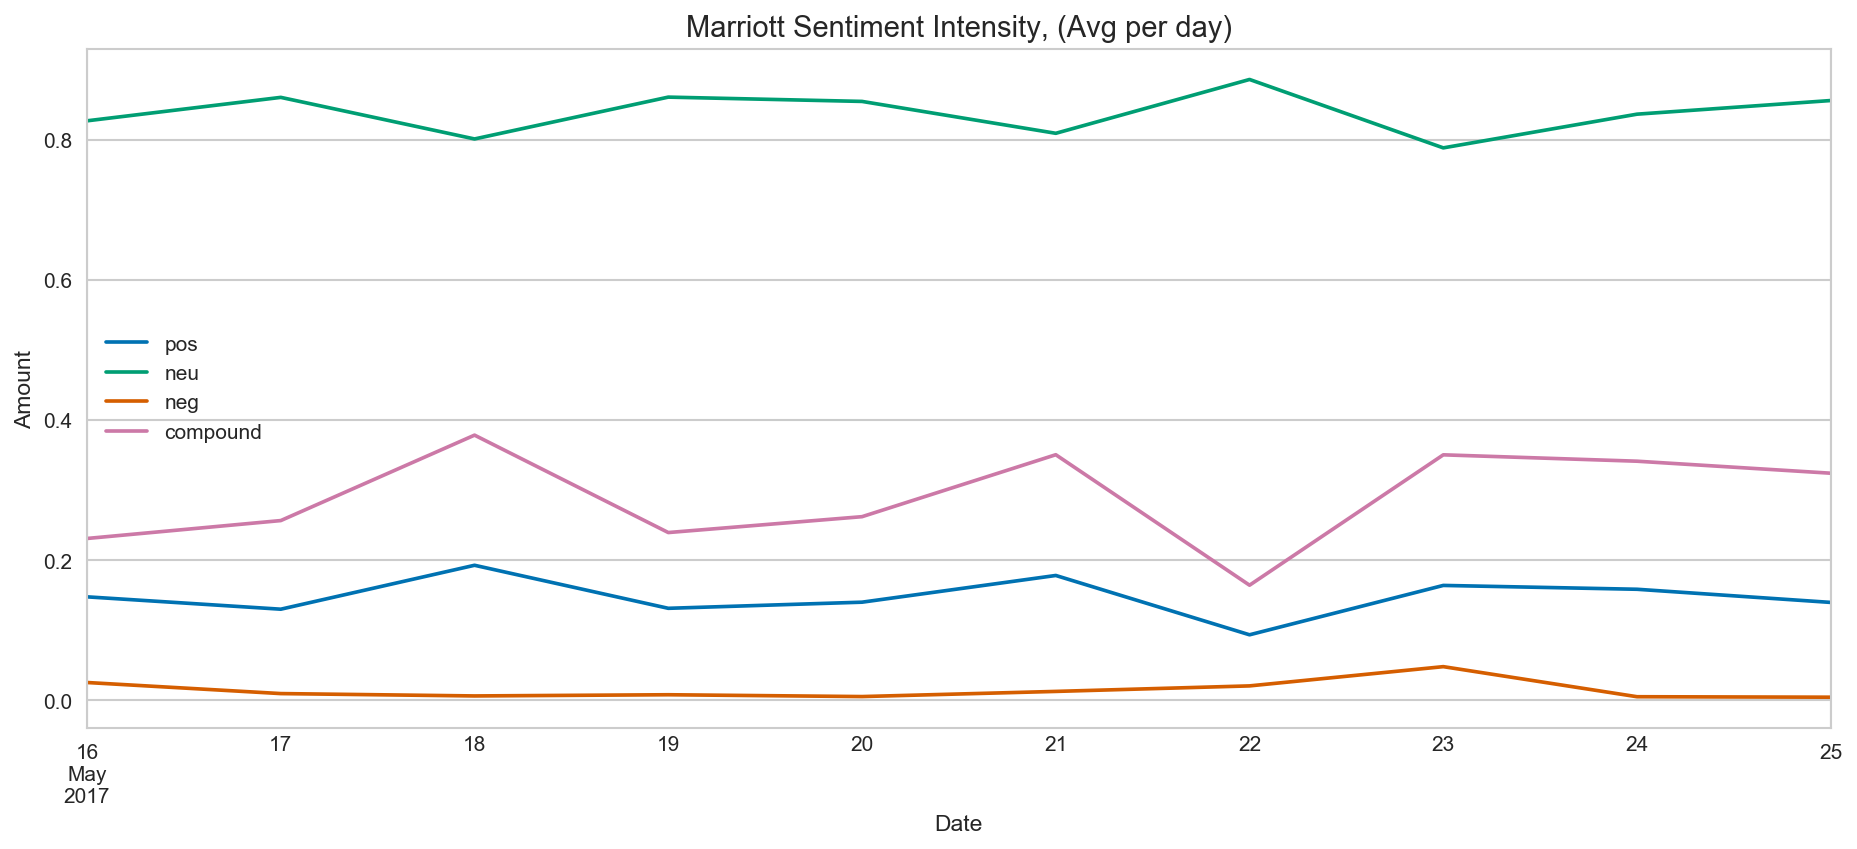

In [320]:
# sns.palplot(sns.color_palette("muted"))
sns.set_palette("colorblind")
# graphing the sentiment count
fig, ax = plt.subplots(figsize=(15,6), dpi=150)
df[df['hashtags']=='#Marriott']['pos'].resample('D').mean().fillna(value=0).plot(ax=ax)#, title='Marriott Sentiment')
ax.set_title('', fontsize=14)

# fig, ax = plt.subplots(figsize=(15,3), dpi=150)
df[df['hashtags']=='#Marriott']['neu'].resample('D').mean().fillna(value=0).plot(ax=ax)#, title='Marriott Sentiment')
ax.set_title('Marriott Sentiment Intensity', fontsize=14)

# fig, ax = plt.subplots(figsize=(15,3), dpi=150)
df[df['hashtags']=='#Marriott']['neg'].resample('D').mean().fillna(value=0).plot(ax=ax)#, title='Marriott Sentiment')
ax.set_title('Marriott Sentiment Intensity', fontsize=14)

# fig, ax = plt.subplots(figsize=(15,3), dpi=150)
df[df['hashtags']=='#Marriott']['compound'].resample('D').mean().fillna(value=0).plot(ax=ax)#, title='Marriott Sentiment')
ax.set_title('Marriott Sentiment Intensity, (Avg per day)', fontsize=14)

ax.legend(loc='center left')
ax.set_xlabel('Date')
ax.set_ylabel('Amount')

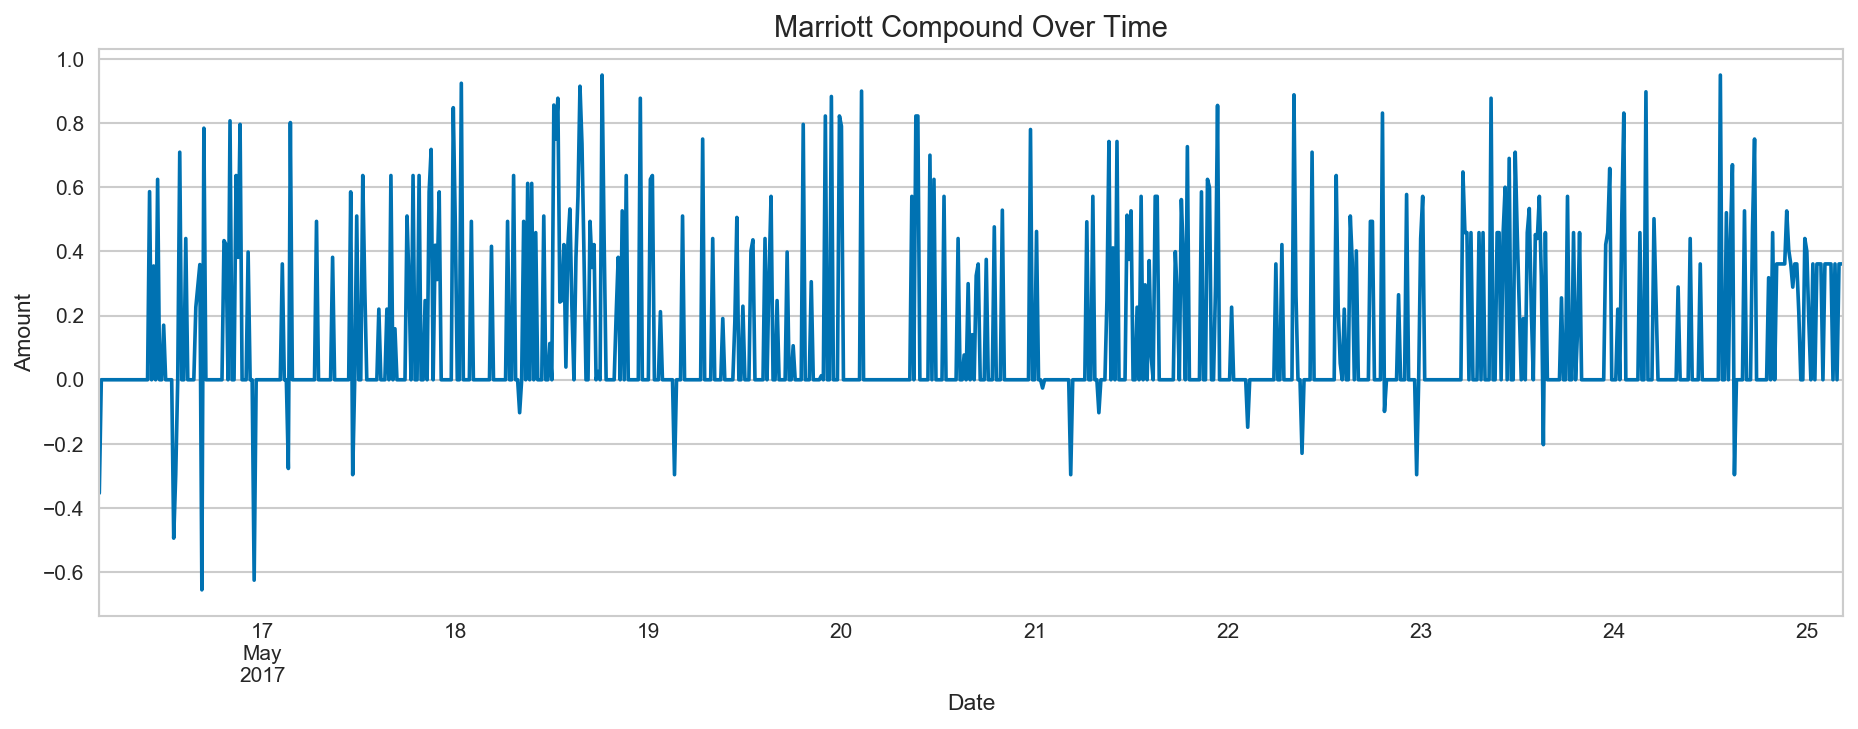

In [321]:
# graphing the sentiment count
fig, ax = plt.subplots(figsize=(15,5), dpi=150)
df[df['hashtags']=='#Marriott']['compound'].resample('15T').mean().fillna(value=0).plot(ax=ax)#, title='Marriott Sentiment')
ax.set_title('Marriott Compound Over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Amount')


In [5]:
# isolating marriott tweets
df_marriott = df[df['hashtags']=='#Marriott']

In [7]:
marriott_neg =  df_marriott[df_marriott['compound'] < 0]

In [9]:
# lda modeling on the marriott negative tweets to see what topics are being talked about the most
# topics will only be specific to each trend/hashtag
vectorizer = CountVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(marriott_neg['text'])

vocab = {v: k for k, v in vectorizer.vocabulary_.iteritems()}

lda = models.LdaMulticore(
    matutils.Sparse2Corpus(X, documents_columns=False),
    num_topics  =  10,
    passes      =  20,
    iterations  =  10,
    workers     =   4,
    id2word     =  vocab
)

In [11]:
# printing the topics
topics = lda.print_topics(num_topics=10, num_words=10)

for topic in topics:
    print topic

(0, u'0.059*"marriott" + 0.031*"kochamwarszawe" + 0.031*"capitol" + 0.031*"pomniksapera" + 0.031*"warsaw" + 0.031*"warszawa" + 0.031*"nightphotography" + 0.031*"children" + 0.031*"sad" + 0.031*"abled"')
(1, u'0.119*"marriott" + 0.054*"hotels" + 0.027*"room" + 0.027*"stop" + 0.027*"seen" + 0.027*"guys" + 0.027*"parking" + 0.027*"bucharest" + 0.027*"valet" + 0.027*"star"')
(2, u'0.063*"marriott" + 0.048*"30" + 0.048*"south" + 0.048*"check" + 0.048*"vacationvilla" + 0.048*"golf" + 0.048*"br" + 0.048*"vacation" + 0.048*"beach" + 0.048*"miami"')
(3, u'0.099*"marriott" + 0.035*"nevermarriott" + 0.035*"battery" + 0.035*"hotel" + 0.035*"stop" + 0.035*"calling" + 0.035*"charged" + 0.035*"calls" + 0.035*"criscyborg" + 0.035*"vegas"')
(4, u'0.059*"marriott" + 0.040*"ps40pp" + 0.040*"plans" + 0.040*"afternoon" + 0.040*"week" + 0.040*"bubbles" + 0.040*"unlimited" + 0.040*"afternoontea" + 0.040*"hanburymanor" + 0.040*"tea"')
(5, u'0.054*"marriott" + 0.019*"holiday" + 0.019*"marbellabeach" + 0.019*"w

In [14]:
# looking at the negative tweets
marriott_neg['token_text']

4                                                [nd, month, cable, totally, directv, signal, entire, hotel]
40      [mad, movies, movie, madness, package, includes, amc, theater, gift, card, marriott, hotel, burli...
42                                                 [stop, smell, rose, wine, dine, marriott, singer, island]
64      [sad, marriott, willing, help, differently, abled, dancers, invited, compete, worlds, inclusion, ...
107     [angry, employee, hacks, marriott, hotels, slashes, online, room, prices, hotels, marriott, marri...
121     [marriott, st, louis, grand, nights, row, false, alarms, minimal, information, guests, way, win, ...
160                                                  [bucharest, star, seen, valet, parking, guys, marriott]
213                                                  [bucharest, star, seen, valet, parking, guys, marriott]
303                                                     [worse, thursdays, marriott, marbellabeach, holiday]
344                

In [22]:
marriott_neg.sample()['token_text'].values[0]

['angry',
 'employee',
 'hacks',
 'marriott',
 'hotels',
 'slashes',
 'online',
 'room',
 'prices',
 'hotels',
 'marriott',
 'marriotthacked']

In [24]:
# test
test_list = ['angry',
 'employee',
 'hacks',
 'marriott',
 'hotels',
 'slashes',
 'online',
 'room',
 'prices',
 'hotels',
 'marriott',
 'marriotthacked']

# Get the negative sentiment score for each word in one of the tweets
for w in test_list:
    print w
    print analyser.polarity_scores(w)['neg']

angry
1.0
employee
0.0
hacks
0.0
marriott
0.0
hotels
0.0
slashes
1.0
online
0.0
room
0.0
prices
0.0
hotels
0.0
marriott
0.0
marriotthacked
0.0


In [72]:
from operator import itemgetter
import operator

# get most negative words
def most_sentiment_words(df_tokenized_series, vader='neg'):
    ''' Finds the most sentiment words, given a pandas series.
    'neg', 'pos', 'neu', and 'compound'
    '''
    neg_dict = {}
    # iterate through each row
    for index, value in df_tokenized_series.iteritems():
        for word in value:
            if word not in neg_dict:
                # word is only added if it is not in the dictionary
                neg_dict[word] = analyser.polarity_scores(word)[vader]
            else:
                pass

    sorted_x = sorted(neg_dict.items(), key=operator.itemgetter(1), reverse=True)
    collected_words = []
    for i in sorted_x:
        if i[1] > 0:
            collected_words.append(i[0])
    collected_words = list(set(collected_words))
    # returns a list of collected words
    return collected_words

In [76]:
# Looking at the most negative words in the hotels dataset
most_sentiment_words(df_tokenized_series=marriott_neg['token_text'], vader='neg')

['slashes',
 'lazy',
 'madness',
 'worse',
 'missing',
 'sluts',
 'horror',
 'hard',
 'stop',
 'sad',
 'worst',
 'mad',
 'alarms',
 'warsaw',
 'angry',
 'charged']

# Modeling

Modeling phase includes  
1. Sentiment Classifier 
2. Word Recommendation System
3. User Aggregation 
4. Location Search

## Classification of tweets based on pos/neg sentiment

Part of the classification stage is to create a vector for each tweet. Earlier on, word2vec was used to create a 300 dimension vector for each word in the corpus of collected tweets. The next step takes each word in a tweet, gets the vector created through the twitter model and googlenews model, adds them up, divides by the total number of words, and it returns the centroid for those group of words. 

Classifying the tweets into positive, neutral, negative sentiment based solely on the tweets' vector.

In [4]:
df = pd.read_csv('./tweets_clean_2017_06_01_07_33_06.csv')
print df.shape
df.sample()

(21583, 24)


,created_at,coordinates,favorite_count,hashtags,location,mined_at,retweet_count,screen_name,source,text,...,longitude,compound,pos,neu,neg,polarity,compound_boosted,primary,secondary,emotions
4933,2017-05-09 16:26:45,"[47.6035690308, -122.329452515]",0.0,#NationalTeachersDay,"Seattle, WA",2017-05-09 09:27:50.676878,74.0,Tonyesc9430,Twitter for Android,on #nationalteachersday sign on if you think teachers deserve better pay better support amp bette...,...,-122.329453,0.875,0.442,0.504,0.054,0.5,0.9847,0.0,1.0,0.0


In [5]:
# Because dataframe was exported to csv and read back in,
# list values became a string
# converting string back to list

def back_to_list(row):
    return row.lstrip('[').rstrip(']').split(', ')

# multiprocessing.... 4 processes
p = Pool(processes=4)

# assigning to column
df.token_text = p.map(back_to_list, df.token_text)
p.close()
p.join()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21583 entries, 0 to 21582
Data columns (total 24 columns):
created_at          21583 non-null object
coordinates         21583 non-null object
favorite_count      21583 non-null float64
hashtags            21583 non-null object
location            20242 non-null object
mined_at            21583 non-null object
retweet_count       21583 non-null float64
screen_name         21583 non-null object
source              21583 non-null object
text                21582 non-null object
token_text          21583 non-null object
tweet_length        21583 non-null int64
word_count          21583 non-null int64
latitude            21583 non-null float64
longitude           21583 non-null float64
compound            21583 non-null float64
pos                 21583 non-null float64
neu                 21583 non-null float64
neg                 21583 non-null float64
polarity            21583 non-null float64
compound_boosted    21583 non-null float64
p

#### GOOGLE NEWS VECS

In [6]:
# GOOGLE NEWS PRELOADED VECTORS
path = './word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True, limit=15000)

print len(w2v.vocab.keys())
#get most similar words:
w2v.most_similar('ball')

15000


[(u'balls', 0.6992625594139099),
 (u'puck', 0.5981724262237549),
 (u'defensively', 0.5454915761947632),
 (u'midfield', 0.5271008014678955),
 (u'scrimmage', 0.5122814774513245),
 (u'offensively', 0.5002037286758423),
 (u'keeper', 0.49917396903038025),
 (u'batted', 0.49849942326545715),
 (u'game', 0.4928431510925293),
 (u'fumbled', 0.4850366711616516)]

#### Twitter Vecs

In [7]:
# Word2Vec model for the twitter words collected
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print "Training model..."
model = Word2Vec(df['token_text'], workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, hs=1 , negative=0)
print 'Model trained...'

print len(model.wv.vocab.keys())

Training model...
Model trained...
4993


In [8]:
model.most_similar('ball')

[('lakeshow', 0.9220893383026123),
 ('nbadraft', 0.916026771068573),
 ('pick', 0.9048552513122559),
 ('lottery', 0.9000529050827026),
 ('trade', 0.8733624815940857),
 ('select', 0.853671133518219),
 ('fultz', 0.8436776995658875),
 ('ers', 0.8381326198577881),
 ('lavar', 0.8369405269622803),
 ('draft', 0.8367965221405029)]

In [9]:
# Resetting index to inline number
df.index = range(0, df.shape[0])
df.head(3)

,created_at,coordinates,favorite_count,hashtags,location,mined_at,retweet_count,screen_name,source,text,...,longitude,compound,pos,neu,neg,polarity,compound_boosted,primary,secondary,emotions
0,2017-05-02 00:12:33,"[43.3867645264, 6.25899982452]",0.0,#RayAllen,Var,2017-05-09 09:27:58.423891,1.0,ClippsPaul,Twitter Web Client,a nous change des reportages #rayallen #shaq #garnett qu'ont vu et revu mdrrre #nbaextra,...,6.259000,0.0,0.0,1.0,0.0,0.0,0.5574,0.0,0.0,0.0
1,2017-05-02 00:52:44,"[37.7771186829, -122.419639587]",0.0,#RayAllen,"San Francisco, CA",2017-05-09 09:27:58.423886,14.0,illmatikkson,Twitter for iPhone,today in history 19 years ago #spikelee's #hegotgame was released starring #denzelwashington and ...,...,-122.419640,0.0,0.0,1.0,0.0,0.0,0.5994,0.0,1.0,0.0
2,2017-05-02 02:03:09,"[39.4432563782, -98.9573364258]",0.0,#RayAllen,"Anywhere, USA",2017-05-09 09:27:58.423864,0.0,Da1nOnlyCMart,Twitter for Android,i'm gucci #rayallen,...,-98.957336,0.0,0.0,1.0,0.0,0.0,0.0000,0.0,0.0,0.0


The following function gets the word vectors for each word, adds them up, divides by the total words, and the result is the centroid for the words in the tweet.

In [10]:
# creates a vector given a sentence/tweet
# takes a list of words, and array size of w2v vector
# OLDER VERSION

def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec+= model[word].reshape((1, size)) + w2v[word].reshape((1,size)) / 2 #tfidf[word]
            count += 1.
            # tfidf_w2v
        except BaseException as e: # handling the case where the token is not
            #print(e)
            try:
                vec+= model[word].reshape((1, size))
                count += 1.
                #continue     # in the corpus. useful for testing.
            except:
                continue
                
    if count != 0:
        # get centroid of sentence
        vec /= count
    return vec

In [16]:
# The training / test split will be 85-15.
df.shape[0] * .85

18345.55

In [12]:
num_features

300

In [13]:
# Function to create targets based on compound score
def get_targets(row):
    if row < 0:
        return 0
    elif row == 0:
        return 1
    else:
        return 2

## TRAIN TEST

In [17]:
num = 18000

from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

# For every tweet, creating a word vector array for tweet
train_vecs_w2v = np.concatenate([buildWordVector(z, num_features) for z in df.token_text[:num]])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, num_features) for z in df.token_text[num:]])
test_vecs_w2v = scale(test_vecs_w2v)

# creating targets: 0 for negative, 1 for neutral, 2 for positive
y_train = df['compound'][:num].map(lambda x: get_targets(x))
y_test  = df['compound'][num:].map(lambda x: get_targets(x))

# re-setting y_test index range so it starts at 0
y_test.index = range(0, test_vecs_w2v.shape[0])

# looking at the shape of arrays to make sure the sizes match
print train_vecs_w2v.shape
print y_train.shape
print test_vecs_w2v.shape
print y_test.shape

(18000, 300)
(18000,)
(3583, 300)
(3583,)


## Baseline Classifier: Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
logreg = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg', multi_class='multinomial')
logreg.fit(train_vecs_w2v, y_train)
logreg.score(test_vecs_w2v, y_test)

0.69076193134245045

In [20]:
# Cross Validation Classification Accuracy
scoring = 'accuracy'
results = cross_val_score(logreg, train_vecs_w2v, y_train, cv=5, scoring=scoring)
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())

# Classification report
predicted = logreg.predict(test_vecs_w2v)
report = classification_report(y_test, predicted)
print(report)

Accuracy: 0.687 (0.031)
             precision    recall  f1-score   support

          0       0.67      0.52      0.58       904
          1       0.76      0.77      0.77      1657
          2       0.60      0.71      0.65      1022

avg / total       0.69      0.69      0.69      3583



The baseline model is classifying the negative, neutral, positive sentiment of tweets. It is doing better on the neutral tweets. But it is doing horrible on the negative tweets.

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

In [23]:
# Making an attempt with an ExtraTreesClassifier
extra = ExtraTreesClassifier(random_state=0, 
                             criterion='entropy', 
                             max_depth=15, 
                             n_estimators=100, 
                             n_jobs=3, 
                             max_features=.5, 
                             class_weight='balanced',
                             min_samples_split=5)

extra.fit(train_vecs_w2v, y_train)
extra.score(test_vecs_w2v, y_test)

0.58219369243650576

In [24]:
# Cross Validation Classification Accuracy
scoring = 'accuracy'
results = cross_val_score(extra, train_vecs_w2v, y_train, cv=5, scoring=scoring, n_jobs=3)
print("Accuracy: %.3f (%.3f)") % (results.mean(), results.std())

# Classification report
predicted = extra.predict(test_vecs_w2v)
report = classification_report(y_test, predicted)
print(report)

Accuracy: 0.553 (0.043)
             precision    recall  f1-score   support

          0       0.58      0.21      0.31       904
          1       0.65      0.74      0.70      1657
          2       0.48      0.65      0.56      1022

avg / total       0.59      0.58      0.56      3583



The extra trees classifier did bad classifying the negative tweets as well. More data will need to be mined in order to increase the recall score. 

## KERAS TEST ONE

In [25]:
train_vecs_w2v.shape

(18000, 300)

In [26]:
# in order for keras to accurately multi-classify, must convert from 1 column to 3 columns
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes=3)
y_test  = keras.utils.np_utils.to_categorical(y_test, num_classes=3)

Train on 18000 samples, validate on 3583 samples
Epoch 1/20
97s - loss: 0.8910 - acc: 0.6024 - val_loss: 0.8610 - val_acc: 0.6296
Epoch 2/20
59s - loss: 0.7968 - acc: 0.6659 - val_loss: 0.8320 - val_acc: 0.6570
Epoch 3/20
65s - loss: 0.7735 - acc: 0.6819 - val_loss: 0.8729 - val_acc: 0.6629
Epoch 4/20
66s - loss: 0.7595 - acc: 0.6871 - val_loss: 0.8166 - val_acc: 0.6612
Epoch 5/20
67s - loss: 0.7460 - acc: 0.6945 - val_loss: 0.8074 - val_acc: 0.6732
Epoch 6/20
66s - loss: 0.7378 - acc: 0.7029 - val_loss: 0.8436 - val_acc: 0.6606
Epoch 7/20
67s - loss: 0.7274 - acc: 0.7026 - val_loss: 0.7860 - val_acc: 0.6827
Epoch 8/20
70s - loss: 0.7267 - acc: 0.7079 - val_loss: 0.8171 - val_acc: 0.6740
Epoch 9/20
70s - loss: 0.7268 - acc: 0.7032 - val_loss: 0.7722 - val_acc: 0.6832
Epoch 10/20
66s - loss: 0.7132 - acc: 0.7136 - val_loss: 0.8111 - val_acc: 0.6788
Epoch 11/20
67s - loss: 0.7146 - acc: 0.7104 - val_loss: 0.7647 - val_acc: 0.6899
Epoch 12/20
68s - loss: 0.7100 - acc: 0.7143 - val_loss: 0

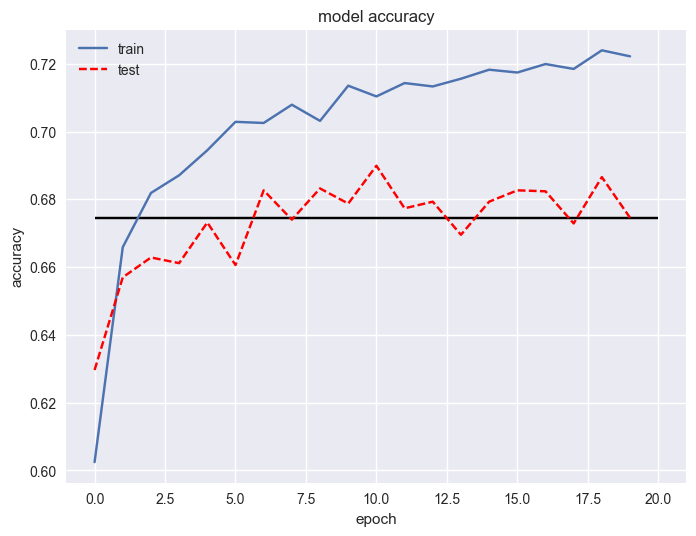

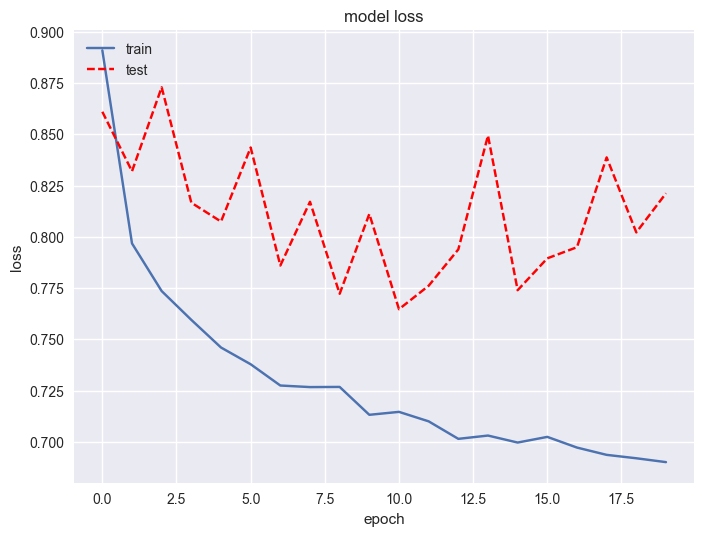

In [30]:
# MULTI-CLASSIFICATION
# Evaluating with a Keras NN

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

from keras.constraints import maxnorm

# Keras neural network deep and wide.
model_keras = Sequential()
model_keras.add(Dropout(0.1, input_shape=(train_vecs_w2v.shape[1],)))
model_keras.add(Dense(500, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.5))
model_keras.add(Dense(800, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.2))
model_keras.add(Dense(1000, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.2))
model_keras.add(Dense(300, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.2))
model_keras.add(Dense(3, activation='softmax'))

epochs = 20
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = .95
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model_keras.compile(loss='categorical_crossentropy',
                    #optimizer=sgd,
                    optimizer='adam',
                    metrics=['accuracy'])

history = model_keras.fit(train_vecs_w2v, y_train, epochs=epochs, validation_data=(test_vecs_w2v, y_test), batch_size=32, verbose=2)

score = model_keras.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=0)

print 'Evaluated score on test data:', score[1]

# summarize history for accuracy
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], c='r', ls='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.hlines(y=score[1], xmin=0, xmax=epochs)
plt.show()

# summarize history for loss
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], c='r', ls='dashed')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
history.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

In [32]:
# Get targets for classification report
y_t  = df['compound'][num:].map(lambda x: get_targets(x))

# Classification report
predicted = model_keras.predict_classes(test_vecs_w2v, verbose=0)
report = classification_report(y_t, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.74      0.39      0.51       904
          1       0.73      0.79      0.76      1657
          2       0.57      0.74      0.65      1022

avg / total       0.69      0.67      0.66      3583



The Keras forward feed network is also having a bad time with the classification of negative tweets.

## KERAS TEST TWO

In [15]:
# in order for keras to accurately multi-classify, must convert from 1 column to 3 columns
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes=3)
y_test  = keras.utils.np_utils.to_categorical(y_test, num_classes=3)

Train on 18000 samples, validate on 3583 samples
Epoch 1/20
3s - loss: 1.1441 - acc: 0.4429 - val_loss: 0.9864 - val_acc: 0.5347
Epoch 2/20
0s - loss: 0.9957 - acc: 0.5252 - val_loss: 0.9594 - val_acc: 0.5507
Epoch 3/20
0s - loss: 0.9586 - acc: 0.5536 - val_loss: 0.9430 - val_acc: 0.5627
Epoch 4/20
0s - loss: 0.9332 - acc: 0.5642 - val_loss: 0.9340 - val_acc: 0.5749
Epoch 5/20
0s - loss: 0.9056 - acc: 0.5877 - val_loss: 0.9198 - val_acc: 0.5808
Epoch 6/20
0s - loss: 0.8914 - acc: 0.5971 - val_loss: 0.9087 - val_acc: 0.5917
Epoch 7/20
0s - loss: 0.8736 - acc: 0.6133 - val_loss: 0.8961 - val_acc: 0.5956
Epoch 8/20
0s - loss: 0.8625 - acc: 0.6176 - val_loss: 0.8856 - val_acc: 0.6045
Epoch 9/20
0s - loss: 0.8465 - acc: 0.6292 - val_loss: 0.8782 - val_acc: 0.6160
Epoch 10/20
0s - loss: 0.8368 - acc: 0.6366 - val_loss: 0.8739 - val_acc: 0.6182
Epoch 11/20
0s - loss: 0.8279 - acc: 0.6437 - val_loss: 0.8682 - val_acc: 0.6280
Epoch 12/20
0s - loss: 0.8174 - acc: 0.6514 - val_loss: 0.8571 - val_

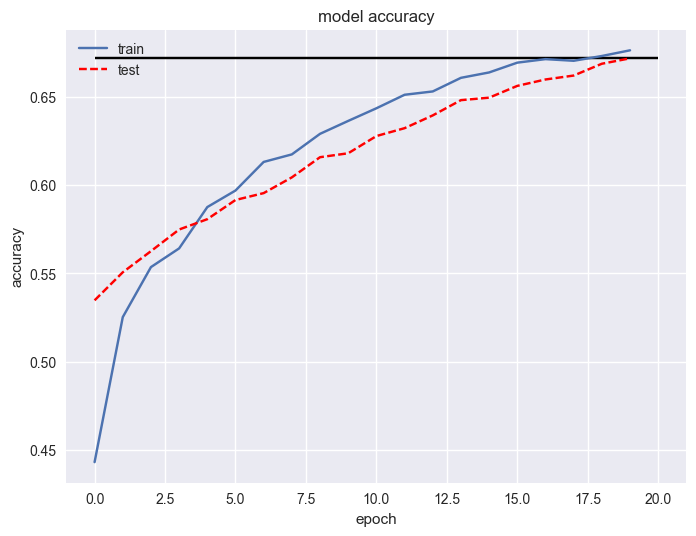

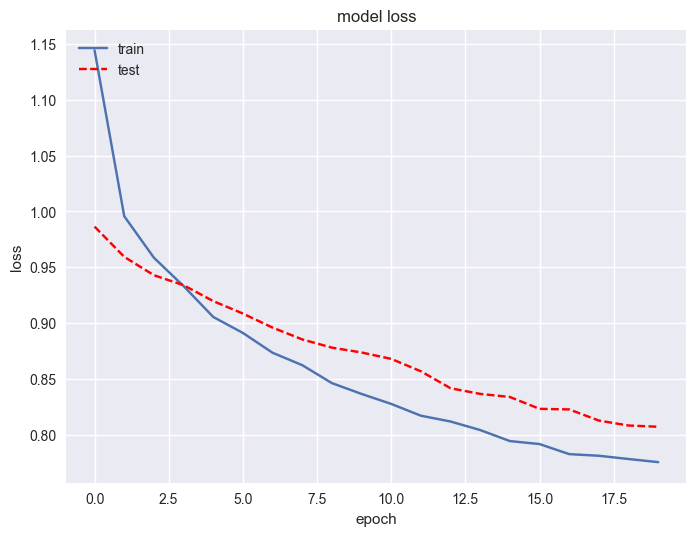

In [47]:
# MULTI-CLASSIFICATION
# Evaluating with a Keras NN

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

from keras.constraints import maxnorm

# Keras neural network short and shallow
model_keras = Sequential()
model_keras.add(Dropout(0.1, input_shape=(train_vecs_w2v.shape[1],)))
model_keras.add(Dense(32, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.3))
model_keras.add(Dense(16, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.2))
model_keras.add(Dense(3, activation='softmax'))

# SGD Parameters
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = .95
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model_keras.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

# Model parameters
epochs = 20
batch = 2048

history = model_keras.fit(train_vecs_w2v, y_train, 
                          validation_data=(test_vecs_w2v, y_test), 
                          epochs=epochs, 
                          batch_size=batch, 
                          verbose=2)

score = model_keras.evaluate(test_vecs_w2v, y_test, 
                             batch_size=batch, verbose=0)

print 'Evaluated score on test data:', score[1]

# summarize history for accuracy
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], c='r', ls='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.hlines(y=score[1], xmin=0, xmax=epochs)
plt.show()

# summarize history for loss
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], c='r', ls='dashed')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# Get targets for classification report
y_t  = df['compound'][num:].map(lambda x: get_targets(x))

# Classification report
predicted = model_keras.predict_classes(test_vecs_w2v, verbose=0)
report = classification_report(y_t, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.70      0.38      0.49       904
          1       0.71      0.81      0.76      1657
          2       0.60      0.71      0.65      1022

avg / total       0.68      0.67      0.66      3583



The short and shallow Keras Neural Network outperformed the deep and shallow one.
- Short and Shallow: Two hidden layers at 32, and 16 neurons. 3 dropout layers set at .1, .5, and .2 in order to minimize overfitting.

There seems to be a pattern with all the classification models. The negative classification is always lower than the rest.

In [61]:
df['target'] = df['compound'].map(lambda x: get_targets(x))
neg = df[df.target == 0]
neu = df[df.target == 1]
pos = df[df.target == 2]

print 'df', df.shape
print 'neg', neg.shape, neg.shape[0]/float(df.shape[0])
print 'neu', neu.shape, neu.shape[0]/float(df.shape[0])
print 'pos', pos.shape, pos.shape[0]/float(df.shape[0])

df (21583, 25)
neg (4727, 25) 0.219014965482
neu (9561, 25) 0.442987536487
pos (7295, 25) 0.337997498031


Looking at the data, The tweets with negative sentiment value are about 20% of the entire dataset. Neutral is at 44%, and positive is at 33%. The most obvious solution to this is to increase the amount fo data so there is an event amount across all three. Another test would be to limit all tweets to the same amount.

In [65]:
# Randomly sampling tweets to a limit of 4000 each
neg_sampled = neg.sample(4000)
neu_sampled = neu.sample(4000)
pos_sampled = pos.sample(4000)

# concating all sampled datasets together
df_test = pd.concat([neg_sampled, neu_sampled, pos_sampled])
df_test.shape

(12000, 25)

In [86]:
# Creating training/testing data, 70/30 split
X_train, X_test, y_train, y_test = train_test_split(df_test.token_text, df_test.target, train_size=0.7)

In [87]:
X_train.sample()

9109    [sethrich, assassination, coverup, feel, youtube, video, saw, responsible, benghazi]
Name: token_text, dtype: object

In [88]:
X_test.sample()

2503    [firefly, pretty, awesome, gotham]
Name: token_text, dtype: object

In [89]:
y_train.sample()

13375    2
Name: target, dtype: int64

In [91]:
y_test_copy = y_test
y_test.sample()

13138    1
Name: target, dtype: int64

In [92]:
# For every tweet, creating a word vector array for tweet
X_train = np.concatenate([buildWordVector(z, num_features) for z in X_train])
X_train = scale(X_train)

X_test = np.concatenate([buildWordVector(z, num_features) for z in X_test])
X_test = scale(X_test)

# looking at the shape of arrays to make sure the sizes match
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(8400, 300)
(8400,)
(3600, 300)
(3600,)


## KERAS TEST THREE

In [93]:
# in order for keras to accurately multi-classify, must convert from 1 column to 3 columns
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes=3)
y_test  = keras.utils.np_utils.to_categorical(y_test, num_classes=3)

Evaluated score on test data: 0.678055544164


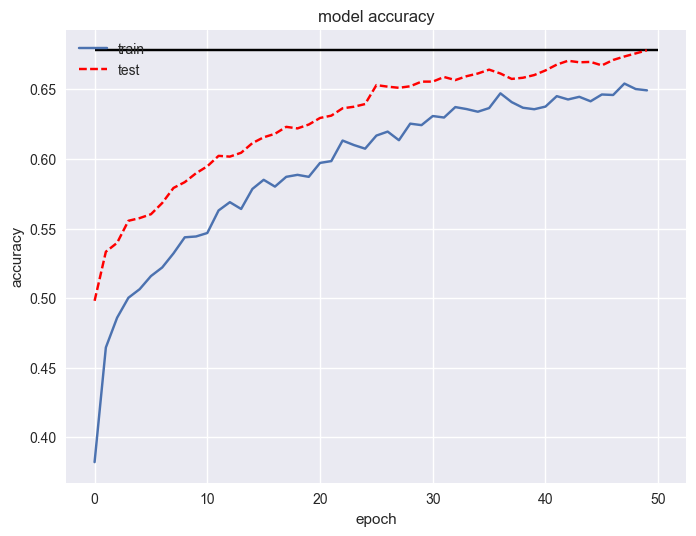

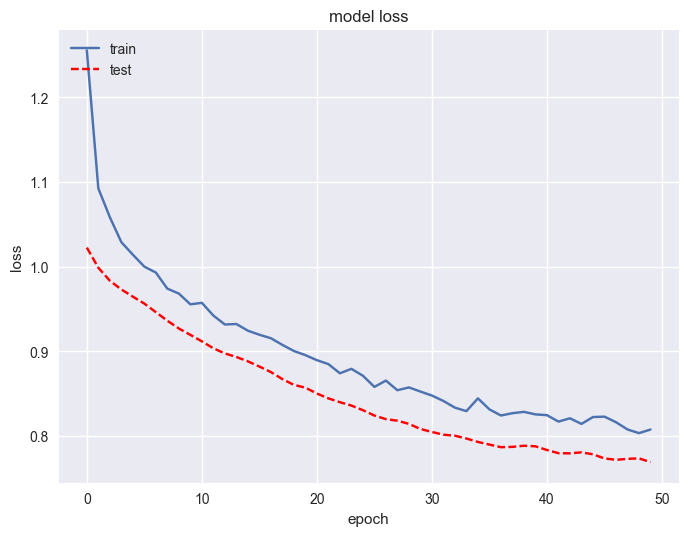

In [98]:
# MULTI-CLASSIFICATION
# Evaluating with a Keras NN

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Keras neural network short and shallow
model_keras = Sequential()
model_keras.add(Dropout(0.1, input_shape=(X_train.shape[1],)))
model_keras.add(Dense(32, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.3))
model_keras.add(Dense(16, activation='relu', kernel_constraint=maxnorm(1)))
model_keras.add(Dropout(0.2))
model_keras.add(Dense(3, activation='softmax'))

# SGD Parameters
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = .95
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model_keras.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

# Model parameters
epochs = 50
batch = 2048

history = model_keras.fit(X_train, y_train, 
                          validation_data=(X_test, y_test), 
                          epochs=epochs, 
                          batch_size=batch, 
                          verbose=0)

score = model_keras.evaluate(X_test, y_test, 
                             batch_size=batch, verbose=0)

print 'Evaluated score on test data:', score[1]

# summarize history for accuracy
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], c='r', ls='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.hlines(y=score[1], xmin=0, xmax=epochs)
plt.show()

# summarize history for loss
plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], c='r', ls='dashed')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [100]:
# Classification report
predicted = model_keras.predict_classes(X_test, verbose=0)
report = classification_report(y_test_copy, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.66      0.62      0.64      1201
          1       0.65      0.75      0.70      1213
          2       0.73      0.66      0.70      1186

avg / total       0.68      0.68      0.68      3600



This third trial the Keras classifier performed better than the first two. Looking at the recall scores, the negative numbers are not looking as bad as before. The next step would be to countvectorize the words in each group. Even though there is an even amount of 4000 data points for each sentiment value, it may be that the neutral has more unique words. Further tests will be in making an attempt to add an LSTM layer in order to add a memory layer, and a convoloution layer in order to find hidden patterns.

The data needed to get a better classifier score has to be specific. It cannot be random tweets. Literally the most negative words have to be searched and collected, as well as the most positive. After doing so, I believe this classifier will do a good as a job as the VADER sentiment analysis.

## Word Recommender

The idea for a word recommendation system came when I saw the power of word2vec. By using word2vec, each word in the entirety of collected tweets becomes associated with one another depending on the context of how it was used. A 300 dimensional vector is created for each word. You are able to perform matrix operations on these vectors, such as a cosine similarity. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. This allows you to find a word that is "most similar" to itself. 

For example, the word 'dog':

In [14]:
# GOOGLE NEWS PRELOADED VECTORS
path = './word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True, limit=5000)

#get most similar words:
w2v.most_similar('dog')

[(u'dogs', 0.868048906326294),
 (u'pet', 0.7164785265922546),
 (u'animal', 0.643801212310791),
 (u'animals', 0.5644524097442627),
 (u'horse', 0.4825807809829712),
 (u'horses', 0.4464002251625061),
 (u'neighbor', 0.3922114968299866),
 (u'child', 0.37009990215301514),
 (u'bear', 0.36609122157096863),
 (u'someone', 0.36170244216918945)]

The top words are the most similar to the word dog, because of the context of how it was used. Depending on the context, 'dog' could be closely related to anything else. The above example is from pre-trained vectors created by Google from its News records. The word count is roughly 3,000,000 words, but I am limiting it to 5000 because of my machines memory use.

The next sample is a tokenized tweet. All stop words have been removed.

In [30]:
temp_list = df_marriott.sample()['token_text'].values[0]
temp_list

['great',
 'room',
 'service',
 'fairview',
 'park',
 'marriott',
 'nice',
 'relax',
 'room']

I want to see what other words are similar to 'great.' 

In [35]:
w2v.most_similar('great')

[(u'fantastic', 0.7935211658477783),
 (u'tremendous', 0.7748856544494629),
 (u'wonderful', 0.7647868990898132),
 (u'good', 0.7291509509086609),
 (u'incredible', 0.7032873630523682),
 (u'amazing', 0.6634127497673035),
 (u'nice', 0.6454657912254333),
 (u'excellent', 0.6124600172042847),
 (u'huge', 0.5829353332519531),
 (u'greatest', 0.5636850595474243)]

A part of the word recommendation system is to iterate over each word in the message, find similar words to it, and return a sentiment score. This allows someone to see how other words will behave in the message.

In [13]:
# Given a word in a word list, word is checked against twitter word2vec model and  google news word2vec.
# If the word exists, it is extracted and used as a sample replacement word
def most_similar_sentence(word_list):
    for word in word_list:
        print word
        print '\t',str(analyser.polarity_scores(word)).lstrip('{').rstrip('}')
        temp_list = []
        if word in model:
            for w in model.most_similar(word)[:5]:
                temp_list.append(w[0])
        if snowball_stemmer.stem(word) in w2v:
            for w in w2v.most_similar(snowball_stemmer.stem(word))[:5]:
                temp_list.append(w[0])
        else:
            continue
        print '\t', temp_list
        
# most_similar_sentence(temp_list)

In [15]:
# function to print sentiment scores
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print "{:-<40}\\n {}".format(sentence, str(snt))

# Function to evaluate score of a phrase

def score_phrase(phrase, similar=False, stopwords=False):
    if similar:
        most_similar_sentence(words_to_wordlist(phrase, remove_stopwords=stopwords))
        print '\n'
    print_sentiment_scores(phrase)
    print '\n'
    psychological_content_analysis(phrase)

# hoteltonight    
score_phrase(phrase='Cool rates for a chill long weekend.', similar=True)
print '\n'
print '\n'
score_phrase(phrase='Nice rates for a long weekend.', similar=False)

cool
	'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182
	['return', 'listen', 'eb', 'try', 'worst', u'warm', u'hot', u'nice', u'calm', u'cold']
rates
	'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0
	[u'rates', u'interest_rates', u'percentage', u'benchmark', u'ratio']
for
	'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0
	[u'give', u'in', u'For', u'giving', u'given']
a
	'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0
chill
	'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0
long
	'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0
	['best', 'true', 'family', 'favorite', 'beating', u'short', u'Long', u'longer', u'longest', u'term']
weekend
	'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0
	['spicey', 'melissamccarthy', 'hmm', 'gifts', 'realized', u'week', u'summer', u'Saturday', u'night', u'Sunday']


Cool rates for a chill long weekend.----\n {'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'compound': 0.3182}


Cool rates for a chill long weekend.
0.75 	Free-form associati

In [299]:
print_sentiment_scores('Rolling On Floor Laughing!')

Rolling On Floor Laughing!--------------
 {'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'compound': 0.5411}


In [126]:
print_sentiment_scores("I just got a call from my boss - does he realise it's Saturday?")

I just got a call from my boss - does he realise it's Saturday?
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


## User Aggregation

The following tests were something interesting I found while working with vectors. If I was able to create a vector for each word in a tweet, and in itself make a vector for the entire tweet, I realized that I can do similar matches against the other tweets. I can create vectors out of any variable and start to do cosine similarities.

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# do a test where the users tweets are aggregated together and a vector is created

In [43]:
# All Tweets are vectorized and saved for most_similar_tweets
tweet_vecs = np.concatenate([buildWordVector(z, num_features) for z in df.token_text])
tweet_vecs = scale(tweet_vecs)

In [142]:
# Function to find most similar tweets
# takes an index, or it can take an actual tweet
# Functions is modeled after word2vec.most_similar()

def most_similar_tweets(tweet=False, index=False, count=10, neg=False):
    '''Given a tweet, will match it to the most similar tweets based on its calculated vector space.
    '''
    most = []
    if tweet:
        tw_vect = buildWordVector(words_to_wordlist(tweet), num_features)[0]
        tw_vect = scale(tw_vect)
        cos_sim = cosine_similarity(tw_vect.reshape(1,-1), tweet_vecs)[0]
        similar = sorted(zip(cos_sim, range(0, df.shape[0])), key=lambda x: x[0], reverse=not neg)[:count]
        for i in similar:
            most.append( (i[0], df.iloc[int(i[1])]['text']) )
    elif tweet == False:
        cos_sim = cosine_similarity(tweet_vecs[index].reshape(1,-1), tweet_vecs)[0]
        similar = sorted(zip(cos_sim, range(0, df.shape[0])), key=lambda x: x[0], reverse=not neg)[:count]
        for i in similar:
            most.append( (i[0], df.iloc[int(i[1])]['text']) )
    return most

In [143]:
def most_similar_users(tweet=False, index=False, count=10, neg=False):
    '''Given a tweet, will match it to the most similar users based on its calculated vector space.
    '''
    most = []
    if tweet:
        tw_vect = buildWordVector(words_to_wordlist(tweet), num_features)[0]
        tw_vect = scale(tw_vect)
        cos_sim = cosine_similarity(tw_vect.reshape(1,-1), tweet_vecs)[0]
        similar = sorted(zip(cos_sim, range(0, df.shape[0])), key=lambda x: x[0], reverse=not neg)[:count]
        for i in similar:
            most.append( (i[0], df.iloc[int(i[1])]['screen_name']) )
    elif tweet == False:
        cos_sim = cosine_similarity(tweet_vecs[index].reshape(1,-1), tweet_vecs)[0]
        similar = sorted(zip(cos_sim, range(0, df.shape[0])), key=lambda x: x[0], reverse=not neg)[:count]
        for i in similar:
            most.append( (i[0], df.iloc[int(i[1])]['screen_name']) )
    return most

In [231]:
# Test with random indices
most_similar_tweets(index=np.random.randint(0, high=df.shape[0]), neg=False)

[(1.0000000000000002, 'the new #amazonecho show with video screen #echoshow'),
 (0.93733756556744374,
  'the new #echoshow has 7 inch screen to display visual information and make video calls with other echo show owners'),
 (0.92926322804323835,
  'amazon unveils the 230 echo show with a screen for calls shipping june 28 #amazon #echoshow #video #calls #tech'),
 (0.92877683137066303,
  's screen on the #echoshow also becomes extremely interesti'),
 (0.92012418166631205,
  '#amazon officially unveiled 230 #echoshow with 7 inch screen for video calling device will be available on june 2'),
 (0.91819119365011503,
  'the new amazon echo 7 inch tablet on a stand has been confirmed #echoshow #intrigued'),
 (0.91686641728907015,
  '#orlandosmarthomes #smarthome #echoshow #thisisorlando #alocalthing #orlandolove'),
 (0.91625440047755591, '#ttah #techtime #echo #echoshow'),
 (0.91625440047755591, '2017 #echo #echoshow'),
 (0.91611999505484398,
  'amazon unveils touchscreen #echoshow w video cal

In [76]:
# Test with tweet that does not exist in the corpus
most_similar_tweets(tweet='Where can I take a vacation?')

[(0.80951959710502885,
  '#marriott vacation club #timeshare resale rental statistics #yes2timeshare #selltimeshare #vacation #resorts'),
 (0.76830155072631179,
  'ditch the motels for your vacation rent a custom beach house #vacation #rentalhome'),
 (0.71593675256211364,
  'last day of #vacation :( #marriott #hollywoodbeach #beach #travel #traveling #traveler #instatravel #instago #hol .'),
 (0.70254666702130808,
  'check out south beach 2 br #mia 6 30 7 7 4 th vacationvilla #miami #vacation #marriott #golf'),
 (0.70254666702130808,
  'check out south beach 2 br #mia 6 30 7 7 4 th vacationvilla #miami #vacation #marriott #golf #traveldeals'),
 (0.68740164314158014, 'on vacation in hawaii #bowwowchallenge'),
 (0.67960618964829234, '#vacation #travel #marriott #hotel #kigali #rwanda'),
 (0.67960618964829234, '#vacation #travel #marriott hotel #kigali #rwanda'),
 (0.65538033805302975,
  "now that's what i call a view #vacation #florida #marriott #timeoff #beach fort lauderdale"),
 (0.653

The following tests create vectors for the users. Each tweet is collected for each user, tweets are aggregated, and a vector is created based off of all the words a user said.

In [101]:
# gather each word said by each unique user
def get_user_words(name, col):
    temp = []
    if col == 'token_text':
        for item, row in df[df['screen_name'] == name][col].iteritems():
            for item in row:
                temp.append(item)
    elif col == 'text':
        for item, row in df[df['screen_name'] == name][col].iteritems():
            temp.append(row)
    return list(set(temp))

In [108]:
# create a dataframe with each users tweets and tokenized tweets
users = []
for user in df.screen_name.unique():
    temp_d = {
            'user'  : user,
            'tokens': get_user_words(user, 'token_text'),
            'tweets': get_user_words(user, 'text')
    }
    users.append(temp_d)

users_df = pd.DataFrame(users)
print users_df.shape
users_df.sample()

(16925, 3)


,tokens,tweets,user
149,"[ouatmusical, existe, emma, descobrem, extra, aps, jennifermorrison, ouat, captainswan, seriado, ...",[extra extra #captainswan descobrem que #emma existe aps a atriz #jennifermorrison sair do seriad...,mama_gime


#### Users Model

In [109]:
# A vector is created for each user based on the words collected.

# Word2Vec model for the twitter words collected
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5           # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print "Training model..."
umodel = Word2Vec(users_df['tokens'], workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, hs=1 , negative=0)
print 'Model trained...'

print len(model.wv.vocab.keys())

Training model...
Model trained...
4993


In [182]:
users_df.sample()

,tokens,tweets,user
6876,"[going, tuesdaymotivation, applause, success, dontgiveup]",[don't give up give yourself applause then keep going #success #tuesdaymotivation #dontgiveup],COACH_Ella


In [111]:
# Using TSNE to to a dimesionality reduction in order to plot onto 2d

from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
#output_notebook()

# getting a list of word vectors. 
#word_vectors = [umodel[w] for w in umodel.wv.vocab.keys()]
word_vectors = np.concatenate([buildWordVector(z, num_features) for z in users_df['tokens'][:500]])


# dimensionality reduction. converting the vectors to 2d vectors
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, method='exact')
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
# tsne_df['words'] = model.wv.vocab.keys()
tsne_df['users'] = users_df['user']
tsne_df['text']  = users_df['tweets']

# RUN THIS TO LOAD BOKEHJS INLINE WITH JUPYTER-NOTEBOOK
output_notebook()

# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_df)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u'Twitter Users',
                   plot_width = 800,
                   plot_height = 600,
                   tools= u'pan, wheel_zoom, box_zoom,'
                           u'box_select, resize, reset',
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@text') )

# draw the words as text on the plot
tsne_plot.text(u'x', u'y', text='users', source=plot_data,
                 text_color=u'black', text_alpha=0.6,
                 text_font_size='10pt')

# configure visual elements of the plot
tsne_plot.title.text_font_size = '16pt'
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# plotting. the corresponding word appears when you hover on the data point.
show(tsne_plot)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.414336
[t-SNE] KL divergence after 100 iterations with early exaggeration: 13.729183
[t-SNE] Error after 175 iterations: 13.729183


Loading BokehJS ...

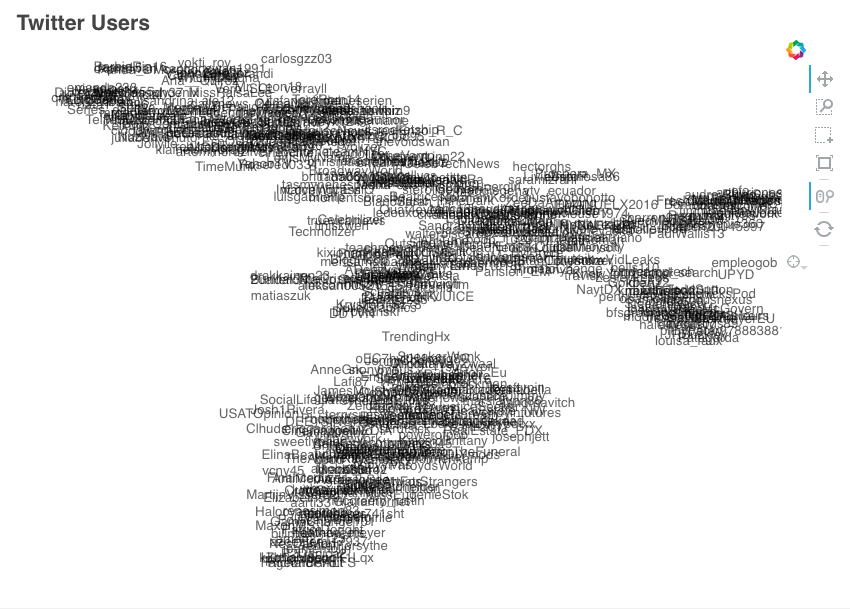

In [135]:
Image(filename='./twitter_users.png')

## Location

The following are tests to plot coordinate data onto maps. It makes it easy to view where the tweets originated from.

In [112]:
import folium
from folium import plugins

In [ ]:
# df.text.astype(str)

In [132]:
# Creating a map with locations from tweets
df_map = folium.Map(location=[37.0902, 95.7129], zoom_start=2)
marker_cluster = folium.MarkerCluster().add_to(df_map)
for name, row in df.sample(100).iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['text']).add_to(marker_cluster)
df_map.save(outfile='twitter_map.html')
# df_map

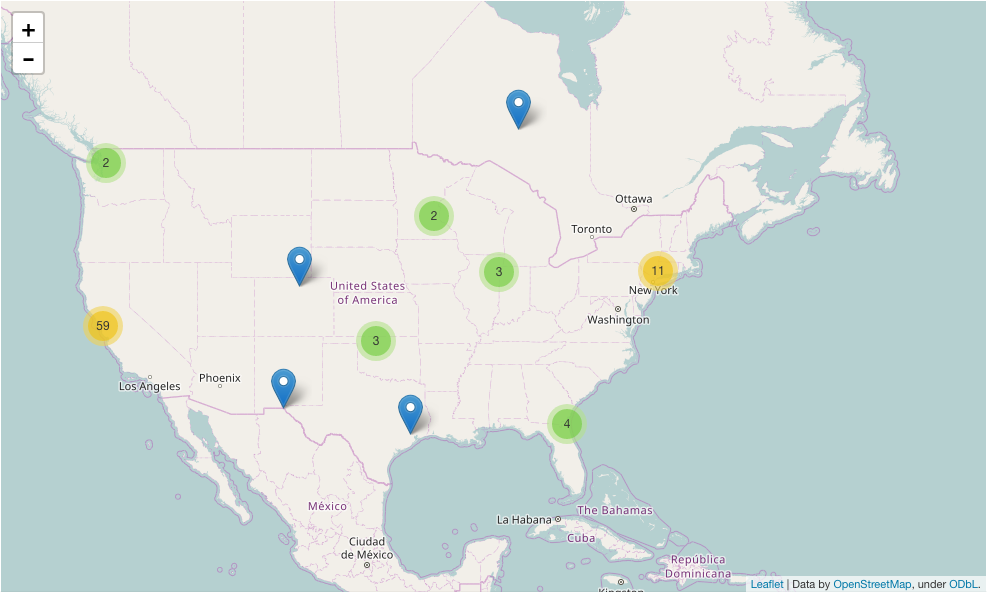

In [131]:
from IPython.display import Image
Image(filename='./usa_map.png')

In [133]:
# Heatmap of tweets
df_heatmap = folium.Map(location=[37.0902, 95.7129], zoom_start=2)
df_heatmap.add_child(plugins.HeatMap([[row["latitude"], row["longitude"]] for name, row in df.sample(200).iterrows()]))
df_heatmap.save("twitter_sample_heatmap.html")
# df_heatmap

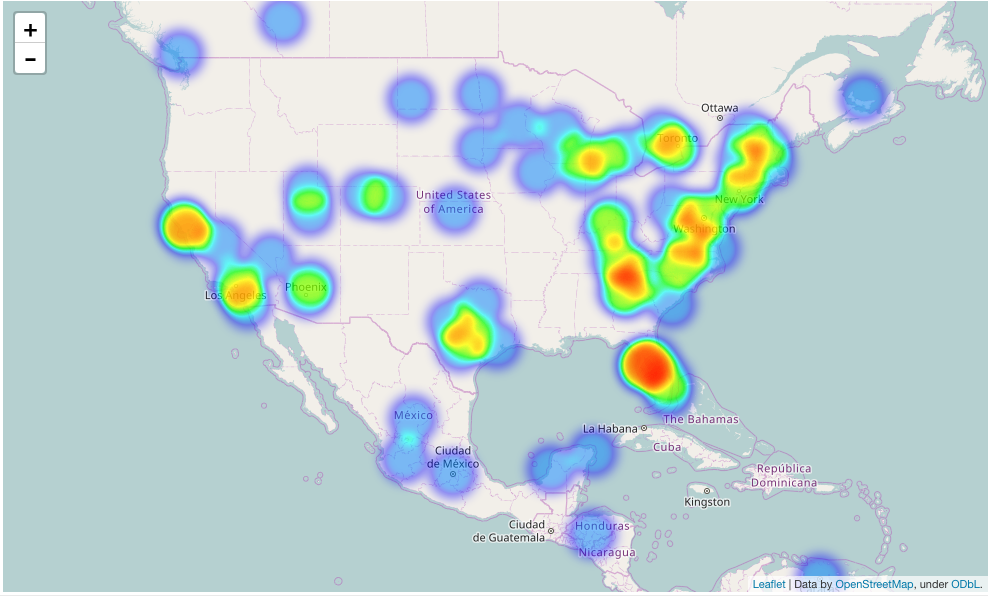

In [134]:
Image(filename='./usa_heatmap.png')

# NEXT STEPS

- Gathering of more tweets to improve classification
- Create a backend so that a website is open to all users
- Experiment more with the vectors. There is so much that can be done!